In [68]:
import nbimporter
import numpy as np
from math import floor


from s04_01_general_Q import \
    get_Q_T_H_d_t_i, \
    get_Q_T_CS_d_t_i, \
    get_Q_T_CL_d_t_i

from s11_01_external_condition import \
    load_outdoor, \
    get_Theta_ex, \
    get_X_ex, \
    calc_h_ex

## 第三節　ルームエアコンディショナー / Section 3  Room Air Conditioner

1．適用範囲～4．記号及び単位は省略

1. Scope of application ~ 4. Symbols and units are omitted

### 5. 最大暖房出力 / Maximum heating output

$$\large
Q_{max,H,d,t} = Qr_{max,H,d,t} \times q_{rtd,H} \times C_{af,H} \times C_{df,H,d,t} \times 3600 \times 10^{-6}
$$

$Q_{max,H,d,t}$：日付$d$の時刻$t$における1時間当たりの最大暖房出力(MJ/h) / Maximum heating output per hour at time $ t $ of date $ d $  
$Qr_{max,H,d,t}$：日付$d$の時刻$t$における最大暖房出力比 / Maximum heating output ratio at time $ t $ of date $ d $  
$q_{rtd,H}$：定格暖房能力(W) / Rated heating capacity  
$C_{af,H}$：室内機吹き出し風量に関する暖房出力補正係数 / Heating output correction factor for indoor unit blowing air volume  
$C_{df,H,d,t}$：日付$d$の時刻$t$におけるデフロストに関する暖房出力補正係数 / Heating output correction factor for defrost at time $ t $ of date $ d $  

In [69]:
def calc_Q_max_H_d_t(Q_r_max_H_d_t, q_rtd_H, Theta_ex, h_ex):
    """最大暖房出力 (1)
    
    :param Q_r_max_H_d_t: 最大暖房出力比
    :type Q_r_max_H_d_t: ndarray
    :param q_rtd_H: 定格暖房能力
    :type q_rtd_H: float
    :param Theta_ex: 外気温度
    :type Theta_ex: ndarray
    :param h_ex: 外気相対湿度
    :type h_ex: ndarray
    :return: 最大暖房出力
    :rtype: ndarray
    """
    # 室内機吹き出し風量に関する暖房時の能力補正係
    C_af_H = get_C_af_H()

    # デフロストに関する暖房出力補正係数
    C_df_H_d_t = get_C_df_H(Theta_ex, h_ex)

    return Q_r_max_H_d_t * q_rtd_H * C_af_H * C_df_H_d_t * 3600 * 10 ** (-6)

$$\large
Qr_{max,H,d,t} = a_2 \times (\theta_{ex,d,t} - 7)^2 + a_1 \times (\theta_{ex,d,t} - 7) + a_0
$$

$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度(℃) / Outside temperature at time $ t $ of date $ d $  

In [70]:
def calc_Q_r_max_H_d_t(q_rtd_C, q_r_max_H, Theta_ex_d_t):
    """最大暖房出力比
    
    :param q_rtd_C:  定格冷房能力
    :type q_rtd_C: float
    :param q_r_max_H: 最大暖房能力比
    :type q_r_max_H: float
    :param Theta_ex_d_t: 外気温度
    :type Theta_ex_d_t: ndarray
    :return: 最大暖房出力比
    :rtype: ndarray
    """
    # 係数a2及びa2,a0
    a2, a1, a0 = calc_a_eq3(q_r_max_H, q_rtd_C)

    return a2 * (Theta_ex_d_t - 7) ** 2 + a1 * (Theta_ex_d_t - 7) + a0

$q_{rtd,C}$が5600(W)を超える場合については、$q_{rtd,C}$は5600(W)に等しいとして計算するものとする。

When $ q_ {rtd, C} $ exceeds 5600 (W), it is assumed that $ q_ {rtd, C} $ is calculated to be equal to 5600 (W).

$$
\Biggl(\begin{matrix}
    a_2\\
    a_1\\
    a_0\\
    \end{matrix}
\Biggr) = 
\Biggl(\begin{matrix}
    b_2\\ 
    b_1\\ 
    b_0\\ 
    \end{matrix}
\Biggr) \times qr_{max,H} + 
\Biggl(\begin{matrix}
    c_2\\ 
    c_1\\ 
    c_0\\ 
    \end{matrix}
\Biggr)
$$

$$
\Biggl(\begin{matrix}
    b_2\\ 
    b_1\\ 
    b_0\\ 
    \end{matrix}
\Biggr) = 
\Biggl(\begin{matrix}
    0.000181\\ 
    0.002322\\ 
    0.003556\\ 
    \end{matrix}
\Biggr) \times q_{rtd,C} \times 10^{-3}  + 
\Biggl(\begin{matrix}
    -0.000184\\ 
    0.013904\\ 
    0.993431\\ 
    \end{matrix}
\Biggr)
$$

$$
\Biggl(\begin{matrix}
    c_2\\ 
    c_1\\ 
    c_0\\ 
    \end{matrix}
\Biggr) = 
\Biggl(\begin{matrix}
    -0.000173\\ 
    -0.003980\\ 
    -0.002870\\ 
    \end{matrix}
\Biggr) \times q_{rtd,C} \times 10^{-3}  + 
\Biggl(\begin{matrix}
    0.000367\\ 
    0.003983\\ 
    0.006376\\ 
    \end{matrix}
\Biggr)
$$

$qr_{max,H}$：最大暖房能力比 / Maximum heating capacity ratio  
$q_{rtd,C}$：定格冷房能力(W) / Rated cooling capacity  

In [71]:
def calc_a_eq3(q_r_max_H, q_rtd_C):
    """係数a2及びa1,a0 (3a)
    
    :param q_r_max_H: 最大暖房能力比
    :type q_r_max_H: float
    :param q_rtd_C:  定格冷房能力
    :type q_rtd_C: float
    :return: 係数a2及びa1,a0 (3a)
    :rtype: tuple
    """
    b2, b1, b0 = get_b_eq3(q_rtd_C)
    c2, c1, c0 = get_c_eq3(q_rtd_C)
    a2 = b2 * q_r_max_H + c2
    a1 = b1 * q_r_max_H + c1
    a0 = b0 * q_r_max_H + c0
    return a2, a1, a0


# 係数b2及びb1,b0 (3b)
def get_b_eq3(q_rtd_C):
    """係数b2及びb1,b0 (3b)
    
    :param q_rtd_C:  定格冷房能力
    :type q_rtd_C: float
    :return: 係数b2及びb1,b0
    :rtype: tuple
    """
    q_rtd_C = min(5600, q_rtd_C)
    b2 = 0.000181 * q_rtd_C * 10 ** (-3) - 0.000184
    b1 = 0.002322 * q_rtd_C * 10 ** (-3) + 0.013904
    b0 = 0.003556 * q_rtd_C * 10 ** (-3) + 0.993431
    return b2, b1, b0


# 係数c2及びc1,c0 (3b)
def get_c_eq3(q_rtd_C):
    """係数c2及びc1,c0 (3b)
    
    :param q_rtd_C:  定格冷房能力
    :type q_rtd_C: float
    :return: 係数c2及びc1,c0
    :rtype: tuple
    """
    q_rtd_C = min(5600, q_rtd_C)
    c2 = -0.000173 * q_rtd_C * 10 ** (-3) + 0.000367
    c1 = -0.003980 * q_rtd_C * 10 ** (-3) + 0.003983
    c0 = -0.002870 * q_rtd_C * 10 ** (-3) + 0.006376
    return c2, c1, c0

$$\large
qr_{max,H} = \frac{q_{max,H}}{q_{rtd,H}}
$$

$q_{max,H}$：最大暖房能力(W) / Maximum heating capacity  
$q_{rtd,H}$：定格暖房能力(W) / Rated heating capacity  

In [72]:
def get_q_r_max_H(q_max_H, q_rtd_H):
    """最大暖房能力比 (4)
    
    :param q_max_H: 最大暖房能力
    :type q_max_H: float
    :param q_rtd_H: 定格暖房能力
    :type q_rtd_H: float
    :return: 最大暖房能力比
    :rtype: float
    """
    q_r_max_H = q_max_H / q_rtd_H
    return q_r_max_H

室内機吹き出し風量に関する暖房時の能力補正係数$C_{af,H}$は0.8とする。  
デフロストに関する暖房出力補正係数$C_{df,H}$は、外気温度が5℃未満かつ相対湿度が80%以上の場合にデフロストが入ると仮定し、その場合の値を0.77とし、 それ以外の条件においては1.0とする。

The capacity correction coefficient $ C_ {af, H} $ at the time of heating relating to the indoor unit blowing air volume is 0.8.  
The heating power correction coefficient $ C_ {df, H} $ for defrost is assumed to be defrosted when the outside air temperature is less than 5 ° C and the relative humidity is 80% or more, and the value in that case is 0.77, otherwise The condition is 1.0.

In [73]:
def get_C_af_H():
    """室内機吹き出し風量に関する暖房時の能力補正係数
    
    :return: 室内機吹き出し風量に関する暖房時の能力補正係
    :rtype: float
    """
    return 0.8


# デフロストに関する暖房出力補正係数
def get_C_df_H(Theta_ex, h_ex):
    """デフロストに関する暖房出力補正係数
    
    :param Theta_ex: 外気温度
    :type Theta_ex: ndarray
    :param h_ex: 外気相対湿度
    :type h_ex: ndarray
    :return: デフロストに関する暖房出力補正係数
    :rtype: ndarray
    """
    C_df_H = np.ones(24 * 365)
    C_df_H[(Theta_ex < 5.0) * (h_ex >= 80.0)] = 0.77
    return C_df_H

### 6. 暖房エネルギー消費量 / Heating energy consumption

#### 6.1 消費電力量 / Power consumption

日付$d$の時刻$t$における補正処理暖房負荷$Q'_{T,H,d,t}$が0の場合、$E_{E,H,d,t}$ = 0とする。

Correction processing at time $t$ of date $ d $ If heating load $ Q'_{T, H, d, t} $ is 0, then $ E_{E, H, d, t} $ = 0.

$$\large
E_{E,H,d,t} = f_{H,\theta} \Biggl( \frac{Q'_{T,H,d,t}}{q_{max,H} \times 3600 \times 10^{-6}} \Biggr) \div 
f_{H,7} \Biggl( \frac{1}{qr_{max,H}} \Biggr) \times \frac{q_{rtd,H}}{e_{rtd,H}} \times 10^{-3}
$$

$E_{E,H,d,t}$：日付$d$の時刻$t$における1時間当たりの消費電力量(kWh/h) / Power consumption per hour at time $ t $ of date $ d $  
$f_{H,\theta}$：基準入出力関数 / Reference input / output function  
$Q'_{T,H,d,t}$：日付$d$の時刻$t$における補正処理暖房負荷(MJ/h) / Correction processing heating load at time $ t $ of date $ d $    
$q_{max,H}$：最大暖房能力(W) / Maximum heating capacity  
$qr_{max,H}$：最大暖房能力比 / Maximum heating capacity ratio  
$q_{rtd,H}$：定格暖房能力(W) / Rated heating capacity  
$e_{rtd,H}$：定格暖房エネルギー消費効率 / Rated heating energy consumption efficiency  

In [74]:
def calc_E_E_H_d_t(region, q_rtd_C, q_rtd_H, e_rtd_H, dualcompressor, L_H_d_t):
    """消費電力量 (5)
    
    :param region: 省エネルギー地域区分
    :type region: int
    :param q_rtd_C: 定格冷房能力
    :type q_rtd_C: float
    :param q_rtd_H: 定格暖房能力
    :type q_rtd_H: float
    :param e_rtd_H: 定格暖房エネルギー消費効率
    :type e_rtd_H: float
    :param dualcompressor: 容量可変型コンプレッサー搭載
    :type dualcompressor: bool
    :param L_H_d_t: 暖冷房区画݅の１時間当たりの暖房負荷 
    :type L_H_d_t: ndarray
    :return: 消費電力量 
    :rtype: ndarray
    """
    # 外気条件
    outdoor = load_outdoor()
    Theta_ex = get_Theta_ex(region, outdoor)
    X_ex = get_X_ex(region, outdoor)
    h_ex = calc_h_ex(X_ex, Theta_ex)

    # 最大暖房能力
    q_max_C = get_q_max_C(q_rtd_C)
    q_max_H = get_q_max_H(q_rtd_H, q_max_C)

    # 最大暖房能力比
    q_r_max_H = get_q_r_max_H(q_max_H, q_rtd_H)

    # 最大暖房出力比
    Q_r_max_H_d_t = calc_Q_r_max_H_d_t(q_rtd_C, q_r_max_H, Theta_ex)

    # 最大暖房出力
    Q_max_H_d_t = calc_Q_max_H_d_t(Q_r_max_H_d_t, q_rtd_H, Theta_ex, h_ex)

    # 処理暖房負荷
    Q_T_H_d_t = get_Q_T_H_d_t_i(Q_max_H_d_t_i=Q_max_H_d_t, L_H_d_t_i=L_H_d_t)

    # 補正処理暖房負荷
    Q_dash_T_H_d_t = calc_Q_dash_T_H_d_t(Q_T_H_d_t, Theta_ex, h_ex)

    # 消費電力量
    E_E_H_d_t = calc_f_H_Theta(Q_dash_T_H_d_t / (q_max_H * 3600 * 10 ** (-6)), q_rtd_C, dualcompressor, Theta_ex) \
                / calc_f_H_Theta(1.0 / q_r_max_H, q_rtd_C, dualcompressor, np.ones(24 * 365) * 7.0) \
                * (q_rtd_H / e_rtd_H) * 10 ** (-3)
    E_E_H_d_t[Q_dash_T_H_d_t == 0.0] = 0.0  # 補正処理暖房負荷が0の場合は0

    return E_E_H_d_t

$$\large
f_{H,\theta}(x) = a_{4}x^{4} + a_{3}x^{3} + a_{2}x^{2} + a_{1}x + a_{0}
$$

In [75]:
def calc_f_H_Theta(x, q_rtd_C, dualcompressor, Theta_ex):
    """基準入出力関数 (6)
    
    :param x: 入力
    :type x: float
    :param q_rtd_C:  定格冷房能力
    :type q_rtd_C: float
    :param dualcompressor: 容量可変型コンプレッサー搭載
    :type dualcompressor: bool
    :param Theta_ex: 外気温度
    :type Theta_ex: ndarray
    :return: 基準入出力関数 
    :rtype: float
    """
    # 係数a0-a4
    a0, a1, a2, a3, a4 = calc_a_eq7(q_rtd_C, dualcompressor, Theta_ex)
    return a4 * x ** 4 + a3 * x ** 3 + a2 * x ** 2 + a1 * x + a0

\begin{equation*}
\left(\begin{matrix}
    a_4\\
    a_3\\
    a_2\\
    a_1\\
    a_0\\
    \end{matrix}
\right) = 
\left(\begin{matrix}
    p_{42} & p_{41} & p_{40}\\
    p_{32} & p_{31} & p_{30}\\
    p_{22} & p_{21} & p_{20}\\
    p_{12} & p_{11} & p_{10}\\
    p_{02} & p_{01} & p_{00}\\
    \end{matrix}
\right)
\left(\begin{matrix}
    \theta_{ex}^2\\ 
    \theta_{ex}\\ 
    1\\ 
    \end{matrix}
\right)
\end{equation*}

In [76]:
def calc_a_eq7(q_rtd_C, dualcompressor, Theta_ex):
    """係数a0～a4
    
    :param q_rtd_C:  定格冷房能力
    :type q_rtd_C: float
    :param dualcompressor: 容量可変型コンプレッサー搭載
    :type dualcompressor: bool
    :param Theta_ex: 外気気温
    :type Theta_ex: ndarray
    :return: 係数a0～a4
    :rtype: tuple
    """
    if dualcompressor == False:
        # 容量可変型コンプレッサー搭載ルームエアコンディショナーでないルームエアコンディショナー
        calc_p_i = calc_p_i_eq8
    else:
        # 容量可変型コンプレッサー搭載ルームエアコンディショナー
        calc_p_i = calc_p_i_eq9

    # 係数p_i
    p_42 = calc_p_i(42, q_rtd_C)
    p_41 = calc_p_i(41, q_rtd_C)
    p_40 = calc_p_i(40, q_rtd_C)
    p_32 = calc_p_i(32, q_rtd_C)
    p_31 = calc_p_i(31, q_rtd_C)
    p_30 = calc_p_i(30, q_rtd_C)
    p_22 = calc_p_i(22, q_rtd_C)
    p_21 = calc_p_i(21, q_rtd_C)
    p_20 = calc_p_i(20, q_rtd_C)
    p_12 = calc_p_i(12, q_rtd_C)
    p_11 = calc_p_i(11, q_rtd_C)
    p_10 = calc_p_i(10, q_rtd_C)
    p_02 = calc_p_i(2, q_rtd_C)
    p_01 = calc_p_i(1, q_rtd_C)
    p_00 = calc_p_i(0, q_rtd_C)

    a4 = p_42 * Theta_ex ** 2 + p_41 * Theta_ex + p_40 * 1
    a3 = p_32 * Theta_ex ** 2 + p_31 * Theta_ex + p_30 * 1
    a2 = p_22 * Theta_ex ** 2 + p_21 * Theta_ex + p_20 * 1
    a1 = p_12 * Theta_ex ** 2 + p_11 * Theta_ex + p_10 * 1
    a0 = p_02 * Theta_ex ** 2 + p_01 * Theta_ex + p_00 * 1

    return a0, a1, a2, a3, a4

$q_{rtd,C}$が5600(W)を超える場合については、$q_{rtd,C}$は5600(W)に等しいとして計算するものとする。

When $ q_{rtd, C} $ exceeds 5600 (W), it is assumed that $ q_{rtd, C} $ is calculated to be equal to 5600 (W).

\begin{equation*}
\large
p_{i} = s_{i} \times q_{rtd,C} \times 10^{-3} + t_{i}
\end{equation*}

$q_{rtd,C}$：定格冷房能力(W) / Rated cooling capacity  

In [77]:
def calc_p_i_eq8(i, q_rtd_C):
    """係数p_i
    
    :param i: [description]
    :type i: int
    :param q_rtd_C:  定格冷房能力
    :type q_rtd_C: float
    :return: 係数p_i
    :rtype: float
    """
    q_rtd_C = min(5600, q_rtd_C)
    # 係数 s_i, t_i
    s_i = calc_s_i_eq8(i)
    t_i = calc_t_i_eq8(i)
    return s_i * q_rtd_C * 10 ** (-3) + t_i


# 係数s_i (i=0,1,2,10..42)
def calc_s_i_eq8(i):
    """係数s_i (i=0,1,2,10..42)
    
    :param i: [description]
    :type i: int
    :return: 係数s_i (i=0,1,2,10..42)
    :rtype: float
    """
    table_3 = get_table_3()    
    return table_3[4 - floor(i / 10)][(2 - (i % 10)) * 2]


# 係数t_i (i=0,1,2,10..42)
def calc_t_i_eq8(i):
    """係数t_i (i=0,1,2,10..42)
    
    :param i: [description]
    :type i: int
    :return: 係数t_i (i=0,1,2,10..42)
    :rtype: float
    """
    table_3 = get_table_3()
    return table_3[4 - floor(i / 10)][(2 - (i % 10)) * 2 + 1]

<div style="text-align: center;font-weight: bold;">表　係数 $s_{i}$ 及び $t_{i}$<br>Table: Coefficients $ s_{i} $ and $ t_{i} $</div>

|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|
|-|-|-|-|-|-|-|-|-|-|-|-|
|$s_{42}$|-0.00236|$t_{42}$|0.01324|$s_{41}$|0.08418|$t_{41}$|-0.47143|$s_{40}$|-1.16944|$t_{40}$|6.54886|
|$s_{32}$|0.00427|$t_{32}$|-0.02392|$s_{31}$|-0.19226|$t_{31}$|0.94213|$s_{30}$|2.58632|$t_{30}$|-12.85618|
|$s_{22}$|-0.00275|$t_{22}$|0.01542|$s_{21}$|0.14947|$t_{21}$|-0.68303|$s_{20}$|-2.03594|$t_{20}$|10.60561|
|$s_{12}$|0.00063|$t_{12}$|-0.00351|$s_{11}$|-0.02865|$t_{11}$|0.10522|$s_{10}$|0.37336|$t_{10}$|-1.09499|
|$s_{02}$|-0.00005|$t_{02}$|0.00028|$s_{01}$|0.00184|$t_{01}$|-0.01090|$s_{00}$|-0.09609|$t_{00}$|0.59229|


In [78]:
def get_table_3():
    """表3 係数s_i及びt_i
    
    :return: 表3 係数s_i及びt_i
    :rtype: list
    """
    # 表3 係数s_i及びt_i
    table_3 = [
        (-0.00236, 0.01324, 0.08418, -0.47143, -1.16944, 6.54886),
        (0.00427, -0.02392, -0.19226, 0.94213, 2.58632, -12.85618),
        (-0.00275, 0.01542, 0.14947, -0.68303, -2.03594, 10.60561),
        (0.00063, -0.00351, -0.02865, 0.10522, 0.37336, -1.09499),
        (-0.00005, 0.00028, 0.00184, -0.01090, -0.09609, 0.59229)
    ]
    return table_3


$q_{rtd,C} \leq 2200$ の場合

If $ q_{rtd, C} \leq 2200 $

$$\large
p_{i} = p_{i,A}
$$

$2200 < q_{rtd,C} \leq 4000$ の場合

If $ 2200 < q_{rtd, C} \leq 4000 $

$$\large
p_{i} = p_{i,A} \times \frac{4000-q_{rtd,C}}{4000-2200} + p_{i,B} \times \frac{q_{rtd,C}-2200}{4000-2200}
$$

$4000 < q_{rtd,C} < 7100$ の場合

If $4000 < q_{rtd,C} < 7100$

$$\large
p_{i} = p_{i,B} \times \frac{7100-q_{rtd,C}}{7100-4000} + p_{i,C} \times \frac{q_{rtd,C}-4000}{7100-4000}
$$

$7100 \leq q_{rtd,C}$ の場合

If $7100 \leq q_{rtd,C}$

$$\large
p_{i} = p_{i,C}
$$

$p_{i,A}$：表により表される係数 / Coefficients represented by a table  
$p_{i,B}$：表により表される係数 / Coefficients represented by a table  
$p_{i,C}$：表により表される係数 / Coefficients represented by a table  

In [79]:
def calc_p_i_eq9(i, q_rtd_C):
    """ 係数p_i (9)
    
    :param i: [description]
    :type i: int
    :param q_rtd_C:  定格冷房能力
    :type q_rtd_C: float
    :raises ValueError: q_rtd_Cが数値でない場合発生する
    :return: 係数p_i (9)
    :rtype: float
    """
    if q_rtd_C <= 2200:
        # (9a)
        return calc_p_i_A(i)
    elif 2200 < q_rtd_C and q_rtd_C <= 4000:
        # (9b)
        p_i_A = calc_p_i_A(i)
        p_i_B = calc_p_i_B(i)
        return p_i_A * ((4000 - q_rtd_C) / (4000 - 2200)) \
               + p_i_B * ((q_rtd_C - 2200) / (4000 - 2200))
    elif 4000 < q_rtd_C and q_rtd_C < 7100:
        # (9c)
        p_i_B = calc_p_i_B(i)
        p_i_C = calc_p_i_C(i)
        return p_i_B * ((7100 - q_rtd_C) / (7100 - 4000)) \
               + p_i_C * ((q_rtd_C - 4000) / (7100 - 4000))
    elif 7100 <= q_rtd_C:
        return calc_p_i_C(i)
    else:
        raise ValueError(q_rtd_C)


In [80]:
def calc_p_i_A(i):
    """係数P_i_A (i=0,1,2,10..42)
    
    :param i: [description]
    :type i: int
    :return: 係数P_i_A (i=0,1,2,10..42)
    :rtype: float
    """
    table_4_A = get_table_4_A()
    return table_4_A[4 - floor(i / 10)][(2 - (i % 10))]


In [81]:
def calc_p_i_B(i):
    """係数P_i_B
    
    :param i: [description]
    :type i: int
    :return: 係数P_i_B
    :rtype: float
    """
    table_4_B = get_table_4_B()
    return table_4_B[4 - floor(i / 10)][(2 - (i % 10))]


In [82]:
def calc_p_i_C(i):
    """係数P_i_C
    
    :param i: [description]
    :type i: int
    :return: 係数P_i_C
    :rtype: float
    """
    table_4_C = get_table_4_C()
    return table_4_C[4 - floor(i / 10)][(2 - (i % 10))]


<div style="text-align: center;font-weight: bold;">表　係数$p_{i,A}$<br>Table: Coefficients $ p_{i, A} $</div>

|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|
|-|-|-|-|-|-|
|$p_{42}$|-0.000056|$p_{41}$|0.000786|$p_{40}$|0.071625|
|$p_{32}$|-0.000145|$p_{31}$|0.003337|$p_{30}$|-0.143643|
|$p_{22}$|-0.000240|$p_{21}$|-0.029471|$p_{20}$|1.954343|
|$p_{12}$|-0.000035|$p_{11}$|-0.050909|$p_{10}$|1.389751|
|$p_{02}$|0.0|$p_{01}$|0.0|$p_{00}$|0.076800|  


In [83]:
def get_table_4_A():
    """ 表4(A) 係数 p_i_A
    
    :return: 表4(A) 係数 p_i_A
    :rtype: list
    """
    # 表4(A) 係数 p_i_A
    table_4_A = [
        (-0.000056, 0.000786, 0.071625),
        (-0.000145, 0.003337, -0.143643),
        (-0.000240, -0.029471, 1.954343),
        (-0.000035, -0.050909, 1.389751),
        (0.0, 0.0, 0.076800)
    ]
    return table_4_A


<div style="text-align: center;font-weight: bold;">表　係数$p_{i,B}$<br>Table: Coefficients $ p_{i,B} $</div>

|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|
|-|-|-|-|-|-|
|$p_{42}$|0.000108|$p_{41}$|-0.035658|$p_{40}$|3.063873|
|$p_{32}$|-0.000017|$p_{31}$|0.062546|$p_{30}$|-5.471556|
|$p_{22}$|-0.000245|$p_{21}$|-0.025126|$p_{20}$|4.057590|
|$p_{12}$|0.000323|$p_{11}$|-0.021166|$p_{10}$|0.575459|
|$p_{02}$|0.0|$p_{01}$|0.000330|$p_{00}$|0.047500| 


In [84]:
def get_table_4_B():
    """ 表4(B) 係数 p_i_B
    
    :return: 表4(B) 係数 p_i_B
    :rtype: list
    """
    # 表4(B) 係数 p_i_B
    table_4_B = [
        (0.000108, -0.035658, 3.063873),
        (-0.000017, 0.062546, -5.471556),
        (-0.000245, -0.025126, 4.057590),
        (0.000323, -0.021166, 0.575459),
        (0.0, 0.000330, 0.047500)
    ]
    return table_4_B


<div style="text-align: center;font-weight: bold;">表　係数$p_{i,C}$<br>Table: Coefficients $ p_{i,C} $</div>

|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|
|-|-|-|-|-|-|
|$p_{42}$|-0.001465|$p_{41}$|-0.030500|$p_{40}$|1.920431|
|$p_{32}$|0.002824|$p_{31}$|0.041081|$p_{30}$|-1.835302|
|$p_{22}$|-0.001929|$p_{21}$|-0.009738|$p_{20}$|1.582898|
|$p_{12}$|0.000616|$p_{11}$|-0.014239|$p_{10}$|0.546204|
|$p_{02}$|0.0|$p_{01}$|-0.000110|$p_{00}$|0.023100|


In [85]:
def get_table_4_C():
    """表4(C) 係数 p_i_C
    
    
    :return: 表4(C) 係数 p_i_C
    :rtype: list
    """
    # 表4(C) 係数 p_i_C
    table_4_C = [
        (-0.001465, -0.030500, 1.920431),
        (0.002824, 0.041081, -1.835302),
        (-0.001929, -0.009738, 1.582898),
        (0.000616, -0.014239, 0.546204),
        (0.0, -0.000110, 0.023100)
    ]
    return table_4_C


$$\large
Q'_{T,H,d,t} = Q_{T,H,d,t} \times \frac{1}{C_{af,H} \times C_{df}}
$$

$Q_{T,H,d,t}$：日付$d$の時刻$t$における1時間当たりの暖房設備機器の処理暖房負荷(MJ/h) / Processing heating load of heating equipment equipment per hour at time $ t $ on date $ d $

In [86]:
def calc_Q_dash_T_H_d_t(Q_T_H_d_t, Theta_ex, h_ex):
    """補正処理暖房負荷 (10)
    
    :param Q_T_H_d_t: 処理負荷
    :type Q_T_H_d_t: ndarray
    :param Theta_ex: 外気温度
    :type Theta_ex: ndarray
    :param h_ex: 外気相対温度
    :type h_ex: ndarray
    :return: 補正処理暖房負荷 (10)
    :rtype: ndarray
    """
    ##室内機吹き出し風量に関する暖房時の能力補正係
    C_af_H = get_C_af_H()

    ##デフロストに関する暖房出力補正係数
    C_d_f = get_C_df_H(Theta_ex, h_ex)

    Q_dash_T_H_d_t = Q_T_H_d_t * (1.0 / (C_af_H * C_d_f))

    return Q_dash_T_H_d_t


#### 6.2 ガス消費量 / Gas consumption

日付$d$の時刻$t$における１時間当たりのガス消費量$E_{G,H,d,t}$は0とする。

It is assumed that gas consumption $ E_{G, H, d, t} $ per hour at time $ t $ of date $ d $ is 0.

In [87]:
def get_E_G_H_d_t():
    """ガス消費量
    
    :return: ガス消費量
    :rtype: ndarray
    """
    return np.zeros(24 * 365)


#### 6.3 灯油消費量 / Kerosene consumption

日付$d$の時刻$t$における１時間当たりの灯油消費量$E_{K,H,d,t}$は0とする。

The kerosene consumption $ E_{K, H, d, t} $ per hour at the time $ t $ of the date $ d $ is 0.

In [88]:
def get_E_K_H_d_t():
    """灯油消費量
    
    :return: 灯油消費量
    :rtype: ndarray
    """
    return np.zeros(24 * 365)


#### 6.4 その他の燃料による一次エネルギー消費量 / Primary energy consumption by other fuels

日付$d$の時刻$t$における１時間当たりのその他の燃料による一次エネルギー消費量$E_{M,H,d,t}$は0とする。

Primary energy consumption $ E_{M, H, d, t} $ by other fuel per hour at time $ t $ of date $ d $ is 0.

In [89]:
def get_E_M_H_d_t():
    """その他の燃料による一次エネルギー消費量
    
    :return: その他の燃料による一次エネルギー消費量
    :rtype: ndarray
    """
    return np.zeros(24 * 365)


### 7. 最大冷房出力 / Maximum cooling output

#### 7.1 最大冷房出力の計算 / Calculation of maximum cooling output

$$\large
Q_{max,C,d,t} = Qr_{max,C,d,t} \times q_{rtd,C} \times C_{af,C} \times C_{hm,C} \times 3600 \times 10^{-6}
$$

$Q_{max,C,d,t}$：日付$d$の時刻$t$における1時間当たりの最大冷房出力(MJ/h) / Maximum cooling output per hour at time $ t $ of date $ d $  
$Qr_{max,C,d,t}$：日付$d$の時刻$t$における最大冷房出力比 / Maximum cooling power ratio at time $ t $ of date $ d $  
$q_{rtd,C}$：定格冷房能力(W) / Rated cooling capacity  
$C_{af,C}$：室内機吹き出し風量に関する冷房出力補正係数 / Cooling output correction factor related to indoor unit blowing air volume  
$C_{hm,C}$：室内機吸い込み湿度に関する冷房出力補正係数 / Cooling output correction factor for indoor unit suction humidity  

In [90]:
def calc_Q_max_C_d_t(Q_r_max_C_d_t, q_rtd_C):
    """最大冷房出力 (11)
    
    :param Q_r_max_C_d_t: 最大冷房出力比 
    :type Q_r_max_C_d_t: ndarray
    :param q_rtd_C: 定格冷房能力
    :type q_rtd_C: float
    :return: 最大冷房出力
    :rtype: ndarray
    """
    # 室内機吸い込み湿度に関する冷房出力補正係数
    C_hm_C = get_C_hm_C()

    # 室内機吹き出し風量に関する冷房出力係数
    C_af_C = get_C_af_C()

    return Q_r_max_C_d_t * q_rtd_C * C_af_C * C_hm_C * 3600 * 10 ** (-6)


$$\large
Qr_{max,C,d,t} = a_2 \times (\theta_{ex,d,t} - 35)^2 + a_1 \times (\theta_{ex,d,t} - 35) + a_0
$$

In [91]:
def calc_Q_r_max_C_d_t(q_r_max_C, q_rtd_C, Theta_ex_d_t):
    """最大冷房出力比 (12)
    
    :param q_r_max_C: 最大冷房能力比 
    :type q_r_max_C: float
    :param q_rtd_C: 定格冷房能力
    :type q_rtd_C: float
    :param Theta_ex_d_t: 1時間当たりの外気温度
    :type Theta_ex_d_t: ndarray
    :return: 最大冷房出力比
    :rtype: ndarray
    """
    a2, a1, a0 = calc_a_eq13(q_r_max_C, q_rtd_C)
    return a2 * (Theta_ex_d_t - 35) ** 2 + a1 * (Theta_ex_d_t - 35) + a0


$q_{rtd,C}$が5600(W)を超える場合については、$q_{rtd,C}$は5600(W)に等しいとして計算するものとする。

When $ q_{rtd, C} $ exceeds 5600 (W), it is assumed that $ q_{rtd, C} $ is calculated to be equal to 5600 (W).

$$
\Biggl(\begin{matrix}
    a_2\\
    a_1\\
    a_0\\
    \end{matrix}
\Biggr) = 
\Biggl(\begin{matrix}
    b_2\\ 
    b_1\\ 
    b_0\\ 
    \end{matrix}
\Biggr) \times qr_{max,C} + 
\Biggl(\begin{matrix}
    c_2\\ 
    c_1\\ 
    c_0\\ 
    \end{matrix}
\Biggr)
$$

$$
\Biggl(\begin{matrix}
    b_2\\ 
    b_1\\ 
    b_0\\ 
    \end{matrix}
\Biggr) = 
\Biggl(\begin{matrix}
    0.000182\\ 
    0.003527\\ 
    -0.011490\\ 
    \end{matrix}
\Biggr) \times q_{rtd,C} \times 10^{-3}  + 
\Biggl(\begin{matrix}
    -0.001480\\ 
    -0.023000\\ 
    1.024328\\ 
    \end{matrix}
\Biggr)
$$

$$
\Biggl(\begin{matrix}
    c_2\\ 
    c_1\\ 
    c_0\\ 
    \end{matrix}
\Biggr) = 
\Biggl(\begin{matrix}
    -0.000350\\ 
    -0.001280\\ 
    0.004772\\ 
    \end{matrix}
\Biggr) \times q_{rtd,C} \times 10^{-3}  + 
\Biggl(\begin{matrix}
    0.000800\\ 
    0.003621\\ 
    -0.011170\\ 
    \end{matrix}
\Biggr)
$$

$qr_{max,C}$：最大冷房能力比 / Maximum cooling capacity ratio  
$q_{rtd,C}$：定格冷房能力(W) / Rated cooling capacity  

In [92]:
def calc_a_eq13(q_r_max_C, q_rtd_C):
    """係数a2及びa1,a0 (13a)
    
    :param q_r_max_C: 最大冷房能力比 
    :type q_r_max_C: float
    :param q_rtd_C: 定格冷房能力
    :type q_rtd_C: float
    :return: 係数a2及びa1,a0 
    :rtype: tuple
    """
    b2, b1, b0 = get_b_eq13(q_rtd_C)
    c2, c1, c0 = get_c_eq13(q_rtd_C)
    a2 = b2 * q_r_max_C + c2
    a1 = b1 * q_r_max_C + c1
    a0 = b0 * q_r_max_C + c0
    return a2, a1, a0


# 係数b2,b1,b0 (13b)
def get_b_eq13(q_rtd_C):
    """係数b2,b1,b0 (13b)
    
    :param q_rtd_C: 定格冷房能力
    :type q_rtd_C: float
    :return: 係数b2,b1,b0
    :rtype: tuple
    """
    q_rtd_C = min(5600, q_rtd_C)
    b2 = 0.000812 * q_rtd_C * 10 ** (-3) - 0.001480
    b1 = 0.003527 * q_rtd_C * 10 ** (-3) - 0.023000
    b0 = -0.011490 * q_rtd_C * 10 ** (-3) + 1.024328
    return b2, b1, b0


# 係数c2,c1,c0 (13c)
def get_c_eq13(q_rtd_C):
    """係数c2,c1,c0 (13c)
    
    :param q_rtd_C: 定格冷房能力
    :type q_rtd_C: float
    :return: 係数c2,c1,c0 
    :rtype: tuple
    """
    q_rtd_C = min(5600, q_rtd_C)
    c2 = -0.000350 * q_rtd_C * 10 ** (-3) + 0.000800
    c1 = -0.001280 * q_rtd_C * 10 ** (-3) + 0.003621
    c0 = 0.004772 * q_rtd_C * 10 ** (-3) - 0.011170
    return c2, c1, c0


$$\large
qr_{max,C} = \frac{q_{max,C}}{q_{rtd,C}}
$$

$q_{max,C}$：最大冷房能力(W) / Maximum cooling capacity  
$q_{rtd,C}$：定格冷房能力(W) / Rated cooling capacity  

In [93]:
def get_q_r_max_C(q_max_C, q_rtd_C):
    """最大冷房能力比 (14)
    
    :param q_max_C: 最大冷房能力
    :type q_max_C: float
    :param q_rtd_C: 定格冷房能力
    :type q_rtd_C: float
    :return: 最大冷房能力比
    :rtype: float
    """
    return q_max_C / q_rtd_C


室内機吹き出し風量に関する冷房時の能力補正係数$C_{af,C}$は0.85とする。  
室内機吸い込み湿度に関する冷房能力補正係数$C_{hm,C}$は1.15とする。

The capacity correction coefficient $ C_{af, C} $ at the time of cooling relating to the indoor unit blowing air volume is set to 0.85.  
The cooling capacity correction coefficient $ C_{hm, C} $ related to indoor unit suction humidity is 1.15.

In [94]:
def get_C_af_C():
    """室内機吹き出し風量に関する冷房時の能力補正係数 C_af_C
    
    :return: 室内機吹き出し風量に関する冷房時の能力補正係数
    :rtype: float
    """
    return 0.85


# 室内機吸い込み湿度に関する冷房能力補正係 C_hm_C
def get_C_hm_C():
    """室内機吸い込み湿度に関する冷房能力補正係数 C_hm_C
    
    :return: 室内機吸い込み湿度に関する冷房能力補正係数
    :rtype: float
    """
    return 1.15


#### 7.2 最大冷房顕熱出力及び最大冷房潜熱出力の計算 / Calculation of maximum cooling sensible heat output and maximum cooling latent heat output

$$\large
Q_{max,CS,d,t} = Q_{max,C,d,t} \times SHF'_{d,t}
$$

$$\large
Q_{max,CL,d,t} = min(Q_{max,C,d,t} \times (1 - SHF'_{d,t}),  L'_{CL,d,t})
$$

$Q_{max,CS,d,t}$：日付$d$の時刻$t$における1時間当たりの最大冷房顕熱出力(MJ/h) / Maximum cooling sensible heat output per hour at time $ t $ of date $ d $  
$Q_{max,CL,d,t}$：日付$d$の時刻$t$における1時間当たりの最大冷房潜熱出力(MJ/h) / Maximum cooling latent heat output per hour at time $ t $ of date $ d $  
$Q_{max,C,d,t}$：日付$d$の時刻$t$における1時間当たりの最大冷房出力(MJ/h) / Maximum cooling output per hour at time $ t $ of date $ d $  
$SHF'_{d,t}$：日付$d$の時刻$t$における冷房負荷補正顕熱比 / Cooling load correction sensible heat ratio at time $ t $ of date $ d $  

In [95]:
def get_Q_max_CS_d_t(Q_max_C_d_t, SHF_dash_d_t):
    """最大冷房顕熱出力 (15a)
    
    :param Q_max_C_d_t: 最大冷房出力
    :type Q_max_C_d_t: ndarray
    :param SHF_dash_d_t: 冷房負荷補正顕熱比
    :type SHF_dash_d_t: ndarray
    :return: 最大冷房顕熱出力
    :rtype: ndarray
    """
    return Q_max_C_d_t * SHF_dash_d_t


In [96]:
def get_Q_max_CL_d_t(Q_max_C_d_t, SHF_dash_d_t, L_dash_CL_d_t):
    """最大冷房潜熱出力 (15b)
    
    :param Q_max_C_d_t: 最大冷房出力
    :type Q_max_C_d_t: ndarray
    :param SHF_dash_d_t: 冷房負荷補正顕熱比
    :type SHF_dash_d_t: ndarray
    :param L_dash_CL_d_t: 1時間当たりの補正冷房潜熱負荷
    :type L_dash_CL_d_t: ndarray
    :return: 最大冷房潜熱出力
    :rtype: ndarray
    """
    return np.clip(Q_max_C_d_t * (1.0 - SHF_dash_d_t), 0, L_dash_CL_d_t)


$$\large
SHF'_{d,t} = \left\{ \begin{array}{ll}
    \frac{L_{CS,d,t}}{L'_{C,d,t}} & (L'_{C,d,t} \neq 0)\\ 
    0 & (L'_{C,d,t} = 0)\\ 
    \end{array}
\right.
$$

$L_{CS,d,t}$：日付$d$の時刻$t$における1時間当たりの冷房顕熱負荷(MJ/h) / Cooling sensible heat load per hour at time $ t $ of date $ d $  
$L'_{C,d,t}$：日付$d$の時刻$t$における1時間当たりの補正冷房負荷(MJ/h) / Corrected cooling load per hour at time $ t $ of date $ d $  

In [97]:
def get_SHF_dash_d_t(L_CS_d_t, L_dash_C_d_t):
    """冷房負荷補正顕熱比 (16)
    
    :param L_CS_d_t: 暖冷房区画の 1 時間当たりの冷房顕熱負荷
    :type L_CS_d_t: ndarray
    :param L_dash_CL_d_t: 1時間当たりの補正冷房潜熱負荷
    :type L_dash_CL_d_t: ndarray
    :return: 冷房負荷補正顕熱比
    :rtype: float
    """
    SHF_dash_d_t = np.zeros(24*365)
    f1 = L_dash_C_d_t > 0
    SHF_dash_d_t[f1] = L_CS_d_t[f1] / L_dash_C_d_t[f1]
    return SHF_dash_d_t


$$\large
L'_{C,d,t} = L_{CS,d,t} + L'_{CL,d,t}
$$

$L_{CS,d,t}$：日付$d$の時刻$t$における1時間当たりの冷房顕熱負荷(MJ/h) / Cooling sensible heat load per hour at time $ t $ of date $ d $  
$L'_{CL,d,t}$：日付$d$の時刻$t$における1時間当たりの補正冷房潜熱負荷(MJ/h) / Corrected cooling latent heat load per hour at time $ t $ of date $ d $  

In [98]:
def get_L_dash_C_d_t(L_CS_d_t, L_dash_CL_d_t):
    """補正冷房負荷 (17)
    
    :param L_CS_d_t: 暖冷房区画の 1 時間当たりの冷房顕熱負荷
    :type L_CS_d_t: ndarray
    :param L_dash_CL_d_t: 1時間当たりの補正冷房潜熱負荷
    :type L_dash_CL_d_t: ndarray
    :return: 補正冷房負荷
    :rtype: ndarray
    """
    return L_CS_d_t + L_dash_CL_d_t


$$\large
L'_{CL,d,t} = min(L_{max,CL,d,t},  L_{CL,d,t})
$$

$L_{max,CL,d,t}$：日付$d$の時刻$t$における1時間当たりの最大冷房潜熱負荷(MJ/h) / Maximum cooling latent heat load per hour at time $ t $ of date $ d $  
$L_{CL,d,t}$：日付$d$の時刻$t$における1時間当たりの冷房潜熱負荷(MJ/h) / Cooling latent heat load per hour at time $ t $ of date $ d $  

In [99]:
def get_L_dash_CL_d_t(L_max_CL_d_t, L_CL_d_t):
    """補正冷房潜熱負荷 (18)
    
    :param L_max_CL_d_t: 1時間当たりの最大冷房潜熱負荷 
    :type L_max_CL_d_t: ndarray
    :param L_CL_d_t: 暖冷房区画の 1 時間当たりの冷房潜熱負荷
    :type L_CL_d_t: ndarray
    :return: 補正冷房潜熱負荷
    :rtype: ndarray
    """
    return np.clip(L_CL_d_t, 0, L_max_CL_d_t)


$$\large
L_{max,CL,d,t} = L_{CS,d,t} \times \frac{1 - SHF_{L,min,c}}{SHF_{L,min,c}}
$$

$L_{CS,d,t}$：日付$d$の時刻$t$における1時間当たりの冷房顕熱負荷(MJ/h) / Cooling sensible heat load per hour at time $ t $ of date $ d $  
$SHF_{L,min,c}$：冷房負荷最小顕熱比 / Cooling load minimum sensible heat ratio  

In [100]:
def get_L_max_CL_d_t(L_CS_d_t, SHF_L_min_c):
    """最大冷房潜熱負荷 (19)
    
    :param L_CS_d_t: 暖冷房区画の 1 時間当たりの冷房顕熱負荷
    :type L_CS_d_t: ndarray
    :param SHF_L_min_c: 冷房負荷最小顕熱比率
    :type SHF_L_min_c: float
    :return: 最大冷房潜熱負荷
    :rtype: ndarray
    """
    return L_CS_d_t * ((1.0 - SHF_L_min_c) / SHF_L_min_c)


冷房負荷最小顕熱比$SHF_{L,min,c}$は0.4とする。

The cooling load minimum sensible heat ratio $ SHF_{L, min, c} $ is 0.4.

In [101]:
def get_SHF_L_min_c():
    """冷房負荷最小顕熱比
    
    :return: 冷房負荷最小顕熱比率
    :rtype: float
    """
    return 0.4


### 8. 冷房エネルギー消費量 / Cooling energy consumption

#### 8.1 消費電力量 / Power consumption

日付$d$の時刻$t$における補正処理冷房負荷 $Q'_{T,c,d,t}$が0の場合、$E_{E,C,d,t}$ = 0とする。

Correction processing at time $ t $ of date $ d $ If cooling load $ Q'_{T, c, d, t} $ is 0, then $ E_{E, C, d, t} $ = 0.

$$\large
E_{E,C,d,t} = f_{C,\theta} \Biggl( \frac{Q'_{T,c,d,t}}{q_{max,C} \times 3600 \times 10^{-6}} \Biggr) \div 
f_{C,35} \Biggl( \frac{1}{qr_{max,C}} \Biggr) \times \frac{q_{rtd,C}}{e_{rtd,C}} \times 10^{-3}
$$

$E_{E,C,d,t}$：日付$d$の時刻$t$における1時間当たりの消費電力量(kWh/h) / Power consumption per hour at time $ t $ of date $ d $  
$f_{C,\theta}$：基準入出力関数 / Reference input / output function    
$Q'_{T,c,d,t}$：日付$d$の時刻$t$における補正処理冷房負荷(MJ/h) / Corrected processing cooling load at time $ t $ of date $ d $    
$q_{max,C}$：最大冷房能力(W) / Maximum cooling capacity    
$q_{rtd,C}$：定格冷房能力(W) / Rated cooling capacity    
$e_{rtd,C}$：定格冷房エネルギー消費効率 / Rated cooling energy consumption efficiency  

In [102]:
def calc_E_E_C_d_t(region, q_rtd_C, e_rtd_C, dualcompressor, L_CS_d_t, L_CL_d_t):
    """消費電力量 (20)
    
    :param region: 省エネルギー地域区分
    :type region: int
    :param q_rtd_C: 定格冷房能力
    :type q_rtd_C: float
    :param e_rtd_C: 定格冷房エネルギー消費効率
    :type e_rtd_C: float
    :param dualcompressor: 容量可変型コンプレッサー搭載
    :type dualcompressor: bool
    :param L_CS_d_t: 暖冷房区画の 1 時間当たりの冷房顕熱負荷
    :type L_CS_d_t: ndarray
    :param L_CL_d_t: 暖冷房区画の 1 時間当たりの冷房潜熱負荷
    :type L_CL_d_t: ndarray
    :return: 消費電力量
    :rtype: ndarray
    """
    # 外気条件
    outdoor = load_outdoor()
    Theta_ex = get_Theta_ex(region, outdoor)
    X_ex = get_X_ex(region, outdoor)
    h_ex = calc_h_ex(X_ex, Theta_ex)

    # 最大冷房能力
    q_max_C = get_q_max_C(q_rtd_C)

    # 最大冷房能力比
    q_r_max_C = get_q_r_max_C(q_max_C, q_rtd_C)

    # 最大冷房出力比
    Q_r_max_C_d_t = calc_Q_r_max_C_d_t(q_r_max_C, q_rtd_C, Theta_ex)

    # 最大冷房出力
    Q_max_C_d_t = calc_Q_max_C_d_t(Q_r_max_C_d_t, q_rtd_C)

    # 冷房負荷最小顕熱比
    SHF_L_min_c = get_SHF_L_min_c()

    # 最大冷房潜熱負荷
    L_max_CL_d_t = get_L_max_CL_d_t(L_CS_d_t, SHF_L_min_c)

    # 補正冷房潜熱負荷
    L_dash_CL_d_t = get_L_dash_CL_d_t(L_max_CL_d_t, L_CL_d_t)
    L_dash_C_d_t = get_L_dash_C_d_t(L_CS_d_t, L_dash_CL_d_t)

    # 冷房負荷補正顕熱比
    SHF_dash_d_t = get_SHF_dash_d_t(L_CS_d_t, L_dash_C_d_t)

    # 最大冷房顕熱出力, 最大冷房潜熱出力
    Q_max_CS_d_t = get_Q_max_CS_d_t(Q_max_C_d_t, SHF_dash_d_t)
    Q_max_CL_d_t = get_Q_max_CL_d_t(Q_max_C_d_t, SHF_dash_d_t, L_dash_CL_d_t)

    # 処理冷房負荷
    Q_T_CS_d_t = get_Q_T_CS_d_t_i(Q_max_CS_d_t_i=Q_max_CS_d_t, L_CS_d_t_i=L_CS_d_t)
    Q_T_CL_d_t = get_Q_T_CL_d_t_i(Q_max_CL_d_t_i=Q_max_CL_d_t, L_CL_d_t_i=L_CL_d_t)

    # 補正処理冷房負荷
    Q_dash_T_C_d_t = calc_Q_dash_T_C_d_t(Q_T_CS_d_t, Q_T_CL_d_t)
    
    # 消費電力量
    E_E_C_d_t = calc_f_C_Theta(Q_dash_T_C_d_t / (q_max_C * 3600 * 10 ** (-6)), Theta_ex, q_rtd_C, dualcompressor) \
                / calc_f_C_Theta(1.0 / q_r_max_C, np.ones(24 * 365) * 35.0, q_rtd_C, dualcompressor) \
                * (q_rtd_C / e_rtd_C) * 10 ** (-3)
    E_E_C_d_t[Q_dash_T_C_d_t == 0.0] = 0.0

    return E_E_C_d_t


$$\large
f_{C,\theta}(x) = a_{4}x^{4} + a_{3}x^{3} + a_{2}x^{2} + a_{1}x + a_{0}
$$

\begin{equation*}
\left(\begin{matrix}
    a_4\\
    a_3\\
    a_2\\
    a_1\\
    a_0\\
    \end{matrix}
\right) = 
\left(\begin{matrix}
    p_{42} & p_{41} & p_{40}\\
    p_{32} & p_{31} & p_{30}\\
    p_{22} & p_{21} & p_{20}\\
    p_{12} & p_{11} & p_{10}\\
    p_{02} & p_{01} & p_{00}\\
    \end{matrix}
\right)
\left(\begin{matrix}
    \theta_{ex}^2\\ 
    \theta_{ex}\\ 
    1\\ 
    \end{matrix}
\right)
\end{equation*}

In [103]:
def calc_f_C_Theta(x, Theta_ex, q_rtd_C, dualcompressor=False):
    """基準入出力関数 (21)
    
    :param x: 入力
    :type x: float
    :param Theta_ex: 外気気温
    :type Theta_ex: ndarray
    :param q_rtd_C:  定格冷房能力
    :type q_rtd_C: float
    :param dualcompressor: 容量可変型コンプレッサー搭載, defaults to False
    :type dualcompressor: bool, optional
    :return: 基準入出力関数の入力xに対する出力
    :rtype: float
    """
    # 係数a0-a4
    a0, a1, a2, a3, a4 = calc_a_eq22(Theta_ex, q_rtd_C, dualcompressor=dualcompressor)

    return a4 * x ** 4 + a3 * x ** 3 + a2 * x ** 2 + a1 * x + a0


In [104]:
def calc_a_eq22(Theta_ex, q_rtd_C, dualcompressor=False):
    """係数a0-a4
    
    :param Theta_ex: 外気気温
    :type Theta_ex: ndarray
    :param q_rtd_C:  定格冷房能力
    :type q_rtd_C: float
    :param dualcompressor: 容量可変型コンプレッサー搭載, defaults to False
    :type dualcompressor: bool, optional
    :return: 係数a0-a4
    :rtype: tuple
    """
    if dualcompressor == False:
        # 容量可変型コンプレッサー搭載ルームエアコンディショナーでないルームエアコンディショナー
        calc_p_i = calc_p_i_eq23
    else:
        # 容量可変型コンプレッサー搭載ルームエアコンディショナー
        calc_p_i = calc_p_i_eq24

    # 係数p_i
    p42 = calc_p_i(42, q_rtd_C)
    p41 = calc_p_i(41, q_rtd_C)
    p40 = calc_p_i(40, q_rtd_C)
    p32 = calc_p_i(32, q_rtd_C)
    p31 = calc_p_i(31, q_rtd_C)
    p30 = calc_p_i(30, q_rtd_C)
    p22 = calc_p_i(22, q_rtd_C)
    p21 = calc_p_i(21, q_rtd_C)
    p20 = calc_p_i(20, q_rtd_C)
    p12 = calc_p_i(12, q_rtd_C)
    p11 = calc_p_i(11, q_rtd_C)
    p10 = calc_p_i(10, q_rtd_C)
    p02 = calc_p_i(2, q_rtd_C)
    p01 = calc_p_i(1, q_rtd_C)
    p00 = calc_p_i(0, q_rtd_C)

    a4 = p42 * Theta_ex ** 2 + p41 * Theta_ex + p40 * 1
    a3 = p32 * Theta_ex ** 2 + p31 * Theta_ex + p30 * 1
    a2 = p22 * Theta_ex ** 2 + p21 * Theta_ex + p20 * 1
    a1 = p12 * Theta_ex ** 2 + p11 * Theta_ex + p10 * 1
    a0 = p02 * Theta_ex ** 2 + p01 * Theta_ex + p00 * 1

    return a0, a1, a2, a3, a4

小能力時高効率型コンプレッサー搭載ルームエアコンディショナーでないルームエアコンディショナーについては、係数$p_{i}$は式により与えられ、係数$s_{i}$及び$t_{i}$は表より表される。
$q_{rtd,C}$が5600(W)を超える場合については、$q_{rtd,C}$は5600(W)に等しいとして計算するものとする。

For room air conditioners that are not room air conditioners with variable displacement compressors, the coefficients $ p_ {i} $ are given by the equation, and the coefficients $ s_ {i} $ and $ t_ {i} $ are represented from the table.  
When $ q_ {rtd, C} $ exceeds 5600 (W), it is assumed that $ q_ {rtd, C} $ is calculated to be equal to 5600 (W).

$$
\begin{equation*}
\large
p_{i} = s_{i} \times q_{rtd,C} \times 10^{-3} + t_{i}
\end{equation*}
$$

$q_{rtd,C}$：定格冷房能力(W) / Rated cooling capacity    

In [105]:
def calc_p_i_eq23(i, q_rtd_C):
    """係数p_i (23)
    
    :param i: [description]
    :type i: int
    :param q_rtd_C:  定格冷房能力
    :type q_rtd_C: float
    :return: 係数p_i
    :rtype: float
    """
    q_rtd_C = min(5600, q_rtd_C)
    s_i = calc_s_i_eq23(i)
    t_i = calc_t_i_eq23(i)
    return s_i * q_rtd_C * 10 ** (-3) + t_i


# 係数s_i (i=0,1,2,10..42)
def calc_s_i_eq23(i):
    """係数s_i (i=0,1,2,10..42)
    
    :param i: [description]
    :type i: int
    :return: 係数s_i 
    :rtype: float
    """
    table_5 = get_table_5()
    return table_5[4 - floor(i / 10)][(2 - (i % 10)) * 2]


# 係数t_i (i=0,1,2,10..42)
def calc_t_i_eq23(i):
    table_5 = get_table_5()
    return table_5[4 - floor(i / 10)][(2 - (i % 10)) * 2 + 1]

<div style="text-align: center;font-weight: bold;">表　係数$s_{i}$及び$t_{i}$<br>Table: Coefficients $ s_{i} $ and $ t_{i} $</div>

|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|
|-|-|-|-|-|-|-|-|-|-|-|-|
|$s_{42}$|0.00000|$t_{42}$|0.00000|$s_{41}$|0.00000|$t_{41}$|0.00000|$s_{40}$|0.00000|$t_{40}$|0.00000|
|$s_{32}$|0.00000|$t_{32}$|0.00000|$s_{31}$|-0.00036|$t_{31}$|0.05080|$s_{30}$|-0.20346|$t_{30}$|0.47765|
|$s_{22}$|0.00000|$t_{22}$|0.00000|$s_{21}$|0.00227|$t_{21}$|-0.03952|$s_{20}$|0.04115|$t_{20}$|0.23099|
|$s_{12}$|0.00000|$t_{12}$|0.00000|$s_{11}$|-0.00911|$t_{11}$|0.07102|$s_{10}$|0.14950|$t_{10}$|-1.07335|
|$s_{02}$|0.00000|$t_{02}$|0.00000|$s_{01}$|0.00044|$t_{01}$|-0.00214|$s_{00}$|-0.06250|$t_{00}$|0.35150|


In [106]:
def get_table_5():
    """表5 係数s_i及びt_i
    
    :return: 表5 係数s_i及びt_i
    :rtype: float
    """
    # 表5 係数s_i及びt_i
    table_5 = [
        (0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000),
        (0.00000, 0.00000, -0.00036, 0.05080, -0.20346, 0.47765),
        (0.00000, 0.00000, 0.00227, -0.03952, 0.04115, 0.23099),
        (0.00000, 0.00000, -0.00911, 0.07102, 0.14950, -1.07335),
        (0.00000, 0.00000, 0.00044, -0.00214, -0.06250, 0.35150)
    ]
    return table_5


小能力時高効率型コンプレッサー搭載ルームエアコンディショナーについては下式により表される。

The variable displacement compressor equipped room air conditioner is represented by the following formula.

$q_{rtd,C} \leq 2200$ の場合

If $ q_ {rtd, C} \leq 2200 $

$$\large
p_{i} = p_{i,A}
$$

$2200 < q_{rtd,C} \leq 4000$ の場合

If $2200 < q_{rtd,C} \leq 4000$

$$\large
p_{i} = p_{i,A} \times \frac{4000-q_{rtd,C}}{4000-2200} + p_{i,B} \times \frac{q_{rtd,C}-2200}{4000-2200}
$$

$4000 < q_{rtd,C} < 7100$ の場合

If $4000 < q_{rtd,C} < 7100$

$$\large
p_{i} = p_{i,B} \times \frac{7100-q_{rtd,C}}{7100-4000} + p_{i,C} \times \frac{q_{rtd,C}-4000}{7100-4000}
$$

$7100 \leq q_{rtd,C}$ の場合

If $7100 \leq q_{rtd,C}$

$$\large
p_{i} = p_{i,C}
$$

$p_{i,A}$：表により表される係数 / Coefficients represented by a table  
$p_{i,B}$：表により表される係数 / Coefficients represented by a table  
$p_{i,C}$：表により表される係数 / Coefficients represented by a table  

In [107]:
def calc_p_i_eq24(i, q_rtd_C):
    """係数p_i (21)
    
    :param i: [description]
    :type i: int
    :param q_rtd_C:  定格冷房能力
    :type q_rtd_C: float
    :raises ValueError: q_rtd_Cが数値でない場合発生する
    :return: 係数p_i 
    :rtype: float
    """
    if q_rtd_C <= 2200:
        # (9a)
        return calc_p_i_A_eq24(i)
    elif 2200 < q_rtd_C and q_rtd_C <= 4000:
        # (9b)
        p_i_A = calc_p_i_A_eq24(i)
        p_i_B = calc_p_i_B_eq24(i)
        return p_i_A * ((4000 - q_rtd_C) / (4000 - 2200)) \
               + p_i_B * ((q_rtd_C - 2200) / (4000 - 2200))
    elif 4000 <= q_rtd_C and q_rtd_C < 7100:
        # (9c)
        p_i_B = calc_p_i_B_eq24(i)
        p_i_C = calc_p_i_C_eq24(i)
        return p_i_B * ((7100 - q_rtd_C) / (7100 - 4000)) \
               + p_i_C * ((q_rtd_C - 4000) / (7100 - 4000))
    elif 7100 <= q_rtd_C:
        return calc_p_i_C_eq24(i)
    else:
        raise ValueError(q_rtd_C)


In [108]:
def calc_p_i_A_eq24(i):
    """ 係数P_i_A (i=0,1,2,10..42)
    
    :param i: [description]
    :type i: int
    :return: 係数P_i_A 
    :rtype: float
    """
    table_6_A = get_table_6_A()
    return table_6_A[4 - floor(i / 10)][(2 - (i % 10))]


def calc_p_i_B_eq24(i):
    """ 係数P_i_B
    
    :param i: [description]
    :type i: int
    :return: 係数P_i_B
    :rtype: float
    """
    table_6_B = get_table_6_B()
    return table_6_B[4 - floor(i / 10)][(2 - (i % 10))]


def calc_p_i_C_eq24(i):
    """ 係数P_i_C
    
    :param i: [description]
    :type i: int
    :return: 係数P_i_C
    :rtype: float
    """
    table_6_C = get_table_6_C()
    return table_6_C[4 - floor(i / 10)][(2 - (i % 10))]

<div style="text-align: center;font-weight: bold;">表　係数$p_{i,A}$<br>Table: Coefficients $ p_{i,A} $</div>

|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|
|-|-|-|-|-|-|
|$p_{42}$|-0.0004078|$p_{41}$|0.01035|$p_{40}$|-0.03248|
|$p_{32}$|0.0|$p_{31}$|0.04099|$p_{30}$|-0.81889|
|$p_{22}$|0.0|$p_{21}$|-0.04615|$p_{20}$|2.10666|
|$p_{12}$|0.0013382|$p_{11}$|-0.01179|$p_{10}$|-0.41778|
|$p_{02}$|0.0000000|$p_{01}$|-0.00102|$p_{00}$|0.09270|


In [109]:
def get_table_6_A():
    """表6(A) 係数 p_i_a
    
    :return: 表6(A) 係数 p_i_a
    :rtype: list
    """   
    # 表6(A) 係数 p_i_A
    table_6_A = [
        (-0.0004078, 0.01035, -0.03248),
        (0.0, 0.04099, -0.818809),
        (0.0, -0.04615, 2.10666),
        (0.0013382, -0.01179, -0.41778),
        (0.0000000, -0.00102, 0.09270)
    ]
    return table_6_A

<div style="text-align: center;font-weight: bold;">表　係数$p_{i,B}$<br>Table: Coefficients $ p_{i,B} $</div>

|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|
|-|-|-|-|-|-|
|$p_{42}$|-0.000056|$p_{41}$|-0.003539|$p_{40}$|-0.430566|
|$p_{32}$|0.0|$p_{31}$|0.015237|$p_{30}$|1.188850|
|$p_{22}$|0.0|$p_{21}$|0.000527|$p_{20}$|-0.304645|
|$p_{12}$|-0.000179|$p_{11}$|0.020543|$p_{10}$|0.130373|
|$p_{02}$|0.0|$p_{01}$|0.000240|$p_{00}$|0.013500|


In [110]:
def get_table_6_B():
    """表6(B) 係数 p_i_b
    
    :return: 表6(B) 係数 p_i_b
    :rtype: list
    """
    # 表6(B) 係数 p_i_B
    table_6_B = [
        (-0.000056, -0.003539, -0.430566),
        (0.0, 0.015237, 1.188850),
        (0.0, 0.000527, -0.304645),
        (-0.000179, 0.020543, 0.130373),
        (0.0, 0.000240, 0.013500)
    ]
    return table_6_B


<div style="text-align: center;font-weight: bold;">表　係数$p_{i,C}$<br>Table: Coefficients $ p_{i,C} $</div>

|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|係数<br>coefficient|値<br>value|
|-|-|-|-|-|-|
|$p_{42}$|-0.0001598|$p_{41}$|0.004848|$p_{40}$|0.047097|
|$p_{32}$|0.0|$p_{31}$|0.016675|$p_{30}$|0.362141|
|$p_{22}$|0.0|$p_{21}$|-0.008134|$p_{20}$|-0.023535|
|$p_{12}$|-0.0000772|$p_{11}$|0.012558|$p_{10}$|0.056185|
|$p_{02}$|0.0|$p_{01}$|-0.000110|$p_{00}$|0.010300|


In [111]:
def get_table_6_C():
    """表6(C) 係数 p_i_C
    
    :return: 表6(C) 係数 p_i_C
    :rtype: list
    """
    # 表6(C) 係数 p_i_C
    table_6_C = [
        (-0.0001598, 0.004848, 0.047097),
        (0.0, 0.016675, 0.362141),
        (0.0, -0.008134, -0.023535),
        (-0.0000772, 0.012558, 0.056185),
        (0.0, -0.000110, 0.010300)
    ]
    return table_6_C


$$\large
Q'_{T,C,d,t} = (Q_{T,CS,d,t} + Q_{T,CL,d,t}) \times \frac{1}{C_{hm,C} \times C_{af,C}}
$$

$Q_{T,CS,d,t}$：日付$d$の時刻$t$における1時間当たりの冷房設備機器の処理冷房顕熱負荷(MJ/h) / Processing cooling sensible heat load of cooling equipment per hour at time $ t $ of date $ d $  
$Q_{T,CL,d,t}$：日付$d$の時刻$t$における1時間当たりの冷房設備機器の処理冷房潜熱負荷(MJ/h) / Processing cooling latent heat load of cooling equipment per hour at time $ t $ of date $ d $  
$C_{hm,C}$：室内機吸い込み湿度に関する冷房出力補正係数 / Cooling output correction factor for indoor unit suction humidity  
$C_{af,C}$：室内機吹き出し風量に関する冷房出力補正係数 / Cooling output correction factor related to indoor unit blowing air volume  

In [112]:
def calc_Q_dash_T_C_d_t(Q_T_CS_d_t, Q_T_CL_d_t):
    """補正処理冷房負荷 (25)
    
    :param Q_T_CS_d_t: 冷房区画の処理冷房顕熱負荷
    :type Q_T_CS_d_t: ndarray
    :param Q_T_CL_d_t: 冷房区画の処理冷房潜熱負荷
    :type Q_T_CL_d_t: ndarray
    :return: 補正処理冷房負荷
    :rtype: ndarray
    """
    # 室内機吸い込み湿度に関する冷房出力補正係数
    C_hm_C = get_C_hm_C()

    # 室内機吹き出し風量に関する冷房出力係数
    C_af_C = get_C_af_C()

    return (Q_T_CS_d_t + Q_T_CL_d_t) * (1.0 / (C_hm_C * C_af_C))


#### 8.2 ガス消費量 / Gas consumption

日付$d$の時刻$t$における１時間当たりのガス消費量$E_{G,C,d,t}$は0とする。

It is assumed that gas consumption $ E_{G, C, d, t} $ per hour at time $ t $ of date $ d $ is 0.

In [113]:
def get_E_G_C_d_t():
    """ガス消費量
    
    :return: ガス消費量
    :rtype: ndarray
    """
    return np.zeros(24 * 365)


#### 8.3 灯油消費量 / Kerosene consumption

日付$d$の時刻$t$における１時間当たりの灯油消費量$E_{K,C,d,t}$は0とする。

The kerosene consumption $ E_{K, C, d, t} $ per hour at the time $ t $ of the date $ d $ is 0.

In [114]:
def get_E_K_C_d_t():
    """灯油消費量
    
    :return: 灯油消費量
    :rtype: ndarray
    """
    return np.zeros(24 * 365)


#### 8.4 その他の燃料による一次エネルギー消費量 / Primary energy consumption by other fuels

日付$d$の時刻$t$における１時間当たりのその他の燃料による一次エネルギー消費量$E_{M,C,d,t}$は0とする。

Primary energy consumption $ E_{M, C, d, t} $ by other fuel per hour at time $ t $ of date $ d $ is 0.

In [115]:
def get_E_M_C_d_t():
    """その他の燃料による一次エネルギー消費量
    
    :return: その他の燃料による一次エネルギー消費量
    :rtype: ndarray
    """
    return np.zeros(24 * 365)


## 付録 A 機器の性能を表す仕様の決定方法 / Appendix A How to determine the specification that represents the performance of the device

### A.1 記号と単位 / Symbol and unit

省略

ommision

### A.2 定格能力 / Rated capacity

$$
\begin{equation*}
\large
q_{rtd,H} = 1.2090 \times q_{rtd,C} - 85.1
\end{equation*}
$$

$q_{rtd,H}$：定格暖房能力(W) / Rated heating capacity    
$q_{rtd,C}$：定格冷房能力(W) / Rated cooling capacity    

In [116]:
def get_q_rtd_H(q_rtd_C):
    """定格暖房能力 (1)
    
    :param q_rtd_C: 定格冷房能力(W)
    :type q_rtd_C: float
    :return: 定格暖房能力 (1)
    :rtype: float
    """
    return 1.2090 * q_rtd_C - 85.1


定格冷房能力$q_{rtd,C}$が5600(W)を超える場合については、定格冷房能力$q_{rtd,C}$は5600(W)に等しいとして計算するものとする。

In the case where the rated cooling capacity $ q_{rtd, C} $ exceeds 5600 (W), the rated cooling capacity $ q_{rtd, C} $ is calculated as being equal to 5600 (W).

$$
\begin{equation*}
\large
q_{rtd,C} = 190.5 \times A_{HCZ} + 45.6
\end{equation*}
$$

$A_{HCZ}$：ルームエアコンディショナーにより暖冷房される暖冷房区画の床面積(m<sup>2</sup>) / Floor area of heating and cooling compartments that are heated and cooled by room air conditioner

In [117]:
def get_q_rtd_C(A_HCZ):
    """定格冷房能力 (2)
    
    :param A_HCZ: 暖冷房区画の床面積 (m2)
    :type A_HCZ: float
    :return: 定格冷房能力
    :rtype: float
    """
    q_rtd_C = 190.5 * A_HCZ + 45.6
    return min(5600, q_rtd_C)


### A.3 最大能力 / Maximum ability

$$
\begin{equation*}
\large
q_{max,H} = 1.7597 \times q_{max,C} - 413.7
\end{equation*}
$$

$q_{max,H}$：最大暖房能力(W) / Maximum heating capacity    
$q_{max,C}$：最大冷房能力(W) / Maximum cooling capacity    

In [118]:
def get_q_max_H(q_rtd_H, q_max_C):
    """最大暖房能力 (3)
    
    :param q_rtd_H: 定格暖房能力
    :type q_rtd_H: float
    :param q_max_C: 最大冷房能力
    :type q_max_C: float
    :return: 最大暖房能力
    :rtype: float
    """
    q_max_H = 1.7597 * q_max_C - 413.7
    return max(q_rtd_H, q_max_H)


定格暖房能力$q_{rtd,H}$が最大暖房能力$q_{max,H}$を超える場合については、最大暖房能力$q_{max,H}$は定格暖房能力$q_{rtd,H}$に等しいとする。

If the rated heating capacity $q_{rtd,H}$ exceeds the maximum heating capacity $q_{max,H}$, the maximum heating capacity $q_{max,H}$ shall be equal to the rated heating capacity $q_{rtd,H}$.

$$
\begin{equation*}
\large
q_{max,C} = 0.8462 \times q_{rtd,C} + 1205.9
\end{equation*}
$$

$q_{rtd,C}$：定格冷房能力(W) / Rated cooling capacity    

定格冷房能力$q_{rtd,C}$が最大冷房能力$q_{max,C}$を超える場合については、最大冷房能力$q_{max,C}$は定格冷房能力$q_{rtd,C}$に等しいとする。

When the rated cooling capacity $q_{rtd,C}$ exceeds the maximum cooling capacity $q_{max,C}$, the maximum cooling capacity $q_{max,C}$ is equal to the rated cooling capacity $q_{rtd,C}$.

In [119]:
def get_q_max_C(q_rtd_C):
    """最大冷房能力 (4)

    :param q_rtd_C:  定格冷房能力
    :type q_rtd_C: float
    :return: 最大冷房能力
    :rtype: float
    """
    q_max_C = 0.8462 * q_rtd_C + 1205.9
    return max(q_rtd_C, q_max_C)


### A.4 定格エネルギー消費効率 / Rated energy consumption efficiency

$$
\begin{equation*}
\large
e_{rtd,H} = 0.77 \times e_{rtd,C} + 1.66
\end{equation*}
$$

$e_{rtd,H}$：定格暖房エネルギー消費効率 / Rated heating energy consumption efficiency    
$e_{rtd,C}$：定格冷房エネルギー消費効率 / Rated cooling energy consumption efficiency    

In [120]:
def get_e_rtd_H(e_rtd_C):
    """定格暖房エネルギー効率 (5)
    
    :param e_rtd_C: 定格冷房エネルギー消費効率
    :type e_rtd_C: float
    :return: 定格暖房エネルギー効率
    :rtype: float
    """
    return 0.77 * e_rtd_C + 1.66


区分（い）

Division (I)

$$
\begin{equation*}
\large
e_{rtd,C} = −0.553 \times 10^{−3} \times q_{rtd,C} + 6.34
\end{equation*}
$$

区分（ろ）

Division (RO)

$$
\begin{equation*}
\large
e_{rtd,C} = −0.504 \times 10^{−3} \times q_{rtd,C} + 5.88
\end{equation*}
$$

区分（は）

Division (HA)

$$
\begin{equation*}
\large
e_{rtd,C} = −0.473 \times 10^{−3} \times q_{rtd,C} + 5.50
\end{equation*}
$$

$q_{rtd,C}$：定格冷房能力(W) / Rated cooling capacity    

In [121]:
def get_e_rtd_C(e_class, q_rtd_C):
    """定格冷房エネルギー効率 (6)
    
    :param e_class: [description]
    :type e_class: str
    :param q_rtd_C: 定格冷房能力
    :type q_rtd_C: float
    :raises ValueError: e_classが「い」または「ろ」または「は」でない場合に発生する
    :return: 定格冷房エネルギー効率
    :rtype: float
    """
    if e_class == 'い':
        # (6a)
        return -0.553 * 10 ** (-3) * q_rtd_C + 6.34
    elif e_class == 'ろ':
        # (6b)
        return -0.504 * 10 ** (-3) * q_rtd_C + 5.88
    elif e_class == 'は' or e_class == '不明' or e_class == None:
        # (6c)
        return -0.473 * 10 ** (-3) * q_rtd_C + 5.50
    else:
        raise ValueError(e_class)


### A.5 小能力時高効率型コンプレッサー搭載の有無 / Equipped with high efficiency compressor for small capacity

省略

ommision

### A.6 複数のルームエアコンディショナーが設置される場合の仕様の決定方法 / How to determine the specifications when multiple room air conditioners are installed

省略

ommision

## 付録 B 小能力時高効率型コンプレッサー搭載ルームエアコンディショナーの定義と判別方法 / Appendix B Definition and determination method of room air conditioner with high efficiency compressor at small capacity

省略

ommision

## 付録 C （参考）可変気筒方式コンプレッサー搭載ルームエアコンディショナーの判別方法 / Appendix C (Reference) Determination method of room air conditioner with variable cylinder type compressor

省略

ommision

## 試算例

In [122]:
def calc_Q_UT_H_d_t(region, q_rtd_C, q_rtd_H, e_rtd_H, L_H_d_t):
    """未処理負荷
    
    :param region: 省エネルギー地域区分
    :type region: int
    :param q_rtd_C: 定格冷房能力
    :type q_rtd_C: float
    :param q_rtd_H: 定格暖房能力
    :type q_rtd_H: float
    :param e_rtd_H: 定格暖房エネルギー消費効率
    :type e_rtd_H: float
    :param L_H_d_t: 暖冷房区画݅の１時間当たりの暖房負荷 
    :type L_H_d_t: ndarray
    :return: 未処理負荷
    :rtype: ndarray
    """
    # 外気条件
    outdoor = load_outdoor()
    Theta_ex = get_Theta_ex(region, outdoor)
    X_ex = get_X_ex(region, outdoor)
    h_ex = calc_h_ex(X_ex, Theta_ex)

    # 最大暖房能力
    q_max_C = get_q_max_C(q_rtd_C)
    q_max_H = get_q_max_H(q_rtd_H, q_max_C)

    # 最大暖房能力比
    q_r_max_H = get_q_r_max_H(q_max_H, q_rtd_H)

    # 最大暖房出力比
    Q_r_max_H_d_t = calc_Q_r_max_H_d_t(q_rtd_C, q_r_max_H, Theta_ex)

    # 最大暖房出力
    Q_max_H_d_t = calc_Q_max_H_d_t(Q_r_max_H_d_t, q_rtd_H, Theta_ex, h_ex)

    # 処理暖房負荷
    Q_T_H_d_t = get_Q_T_H_d_t_i(Q_max_H_d_t_i=Q_max_H_d_t, L_H_d_t_i=L_H_d_t)

    return L_H_d_t - Q_T_H_d_t

In [123]:
def get_default_room_air_conditioner():
    
    house_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87,"eta_A_H": 4.3, "eta_A_C": 2.8}

    H_MR = {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False}
    H_OR = None
    C_MR = {"type": "ルームエアコンディショナー", 'e_class': 'ろ', 'dualcompressor': False}
    C_OR = None
    i = 1
    
    return house_base, H_MR, H_OR, C_MR, C_OR, i
    

In [124]:
def calc_results(param, H_MR, H_OR, C_MR, C_OR, i):

    if __name__ == "__main__":

        from s02_01_b_heat_conversion_coefficient import get_f_prim
        from s03_01_hc_load_general import get_Q, get_A_HCZ_i
        from s03_02_envelope_performance import calc_r_env, get_Q_dash, get_eta_H, get_eta_C
        from s04_01_general import calc_heating_load, get_alpha_UT_H_MR, get_alpha_UT_H_OR, calc_cooling_load
        from s04_01_a_heating_method import calc_heating_mode



        region = param["region"]
        sol_region = None
        A_A = param["A_A"]
        A_MR = param["A_MR"]
        A_OR = param["A_OR"]
        A_env = param["A_env"]
        U_A = param["U_A"]
        eta_A_H = param["eta_A_H"]
        eta_A_C = param["eta_A_C"]
        NV_MR = 0
        NV_OR = 0
        r_A_ufvnt = None
        underfloor_insulation = False
        TS = None
        HEX = None

        mode_C = "居室のみを冷房する方式"
        mode_H = '居室のみを暖房する方式でかつ主たる居室とその他の居室ともに温水暖房を設置する場合に該当しない場合'

        # 暖冷房区画の床面積
        A_HCZ = get_A_HCZ_i(i, A_A, A_MR, A_OR)

        # 床面積の合計に対する外皮の部位の面積の合計の比
        r_env = calc_r_env(method='当該住戸の外皮の部位の面積等を用いて外皮性能を評価する方法',
                           A_env=A_env, A_A=A_A)

        # 熱損失係数
        Q_dash = get_Q_dash(U_A, r_env)
        Q = get_Q(Q_dash)

        # 日射取得係数
        mu_H = get_eta_H(eta_A_H, r_env)
        mu_C = get_eta_C(eta_A_C, r_env)

        # 暖房方式及び運転方法の区分
        mode_MR, mode_OR = calc_heating_mode(region=region, H_MR=H_MR, H_OR=H_OR)

        
        
        # 冷房機器の性能
        dualcompressor = C_MR["dualcompressor"] if i == 1 else C_OR["dualcompressor"]
        e_class = C_MR['e_class'] if i == 1 else C_OR["e_class"]
        q_rtd_C = get_q_rtd_C(A_HCZ)
        e_rtd_C = get_e_rtd_C(e_class, q_rtd_C)

        # 冷房負荷
        L_CS_d_t_i, L_CL_d_t_i = calc_cooling_load(region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, r_A_ufvnt, underfloor_insulation,
                          mode_C, mode_H, mode_MR, mode_OR, TS, HEX)
        L_CS_d_t = L_CS_d_t_i[i - 1]
        L_CL_d_t = L_CL_d_t_i[i - 1]

        # 冷房用エネルギー消費量
        E_E_C_d_t =calc_E_E_C_d_t(region, q_rtd_C, e_rtd_C, dualcompressor, L_CS_d_t, L_CL_d_t)
        E_G_C_d_t = get_E_G_C_d_t()
        E_K_C_d_t = get_E_K_C_d_t()
        E_M_C_d_t = get_E_M_C_d_t()



        # 暖房機器の性能
        dualcompressor = H_MR["dualcompressor"] if i == 1 else H_OR["dualcompressor"]
        e_class = H_MR['e_class'] if i == 1 else H_OR["e_class"]
        e_rtd_C = get_e_rtd_C(e_class, q_rtd_C)
        q_rtd_H = get_q_rtd_H(q_rtd_C)
        e_rtd_H = get_e_rtd_H(e_rtd_C)

        # 暖房負荷
        L_H_d_t = \
            calc_heating_load(region, sol_region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX,
                              underfloor_insulation, mode_H, mode_C, spec_MR=H_MR, spec_OR=H_OR, mode_MR=mode_MR, mode_OR=mode_OR, SHC=None)[0][i-1]

        # 暖房用エネルギー消費量
        E_E_H_d_t = calc_E_E_H_d_t(region, q_rtd_C, q_rtd_H, e_rtd_H, dualcompressor, L_H_d_t)
        E_G_H_d_t = get_E_G_H_d_t()
        E_K_H_d_t = get_E_K_H_d_t()
        E_M_H_d_t = get_E_M_H_d_t()

        # 未処理暖房負荷の設計一次エネルギー消費量相当値
        Q_UT_H_d_t = calc_Q_UT_H_d_t(region, q_rtd_C, q_rtd_H, e_rtd_H, L_H_d_t)
        alpha_UT_H = get_alpha_UT_H_MR(region, mode_MR) if i == 1 else get_alpha_UT_H_OR(region, mode_OR)
        E_UT_H_d_t = Q_UT_H_d_t * alpha_UT_H

        

        f_prim = get_f_prim()
        E_H_d_t = E_E_H_d_t * f_prim / 1000 + E_G_H_d_t + E_K_H_d_t + E_M_H_d_t + E_UT_H_d_t
        E_C_d_t = E_E_C_d_t * f_prim / 1000 + E_G_C_d_t + E_K_C_d_t + E_M_C_d_t
        print('E_H(i={}):{}MJ/y'.format(i, np.sum(E_H_d_t)))
        print('E_C(i={}):{}MJ/y'.format(i, np.sum(E_C_d_t)))


        return E_H_d_t, E_C_d_t

In [125]:
def get_each_graph(_E_H_d_t, _E_C_d_t):

    import matplotlib.pyplot as plt

    _E_H_d = np.sum(_E_H_d_t.reshape(365, 24), axis=1)
    _E_C_d = np.sum(_E_C_d_t.reshape(365, 24), axis=1)

    fig = plt.figure(figsize = (20,7))

    grh_day = fig.add_subplot(211)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(_E_H_d, label="E_H")
    grh_day.plot(_E_C_d, label="E_C")
    grh_day.legend()

    grh_date = fig.add_subplot(212)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')
    grh_date.plot(_E_C_d_t.reshape(365,24)[151], label = "E_C:6/1")
    grh_date.plot(_E_C_d_t.reshape(365,24)[212], label = "E_C:8/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[334], label = "E_H:12/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[59], label = "E_H:3/1")
    grh_date.legend()

    plt.show()


### 計算条件1

- 初期条件での計算

In [126]:
house_base, H_MR, H_OR, C_MR, C_OR, i = get_default_room_air_conditioner()

E_H_d_t_1, E_C_d_t_1 = calc_results(house_base, H_MR, H_OR, C_MR, C_OR, i)


E_H(i=1):10478.692099447626MJ/y
E_C(i=1):3287.9122989004436MJ/y


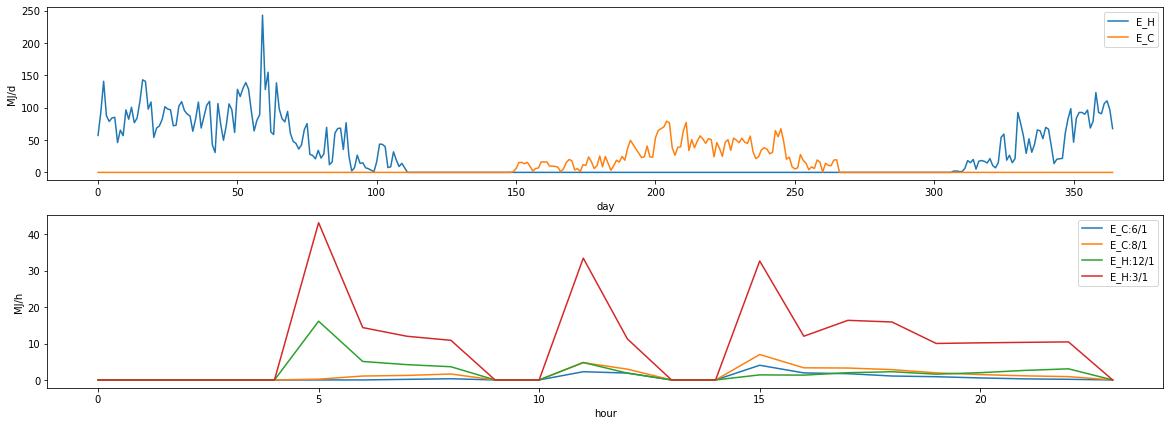

In [127]:
get_each_graph(E_H_d_t_1, E_C_d_t_1)

### 計算条件2

- 地域区分を7地域に変更

In [128]:
house_base, H_MR, H_OR, C_MR, C_OR, i = get_default_room_air_conditioner()
house_base['region'] = 7


E_H_d_t_2, E_C_d_t_2 = calc_results(house_base, H_MR, H_OR, C_MR, C_OR, i)

E_H(i=1):5382.819129465823MJ/y
E_C(i=1):4201.703719660854MJ/y


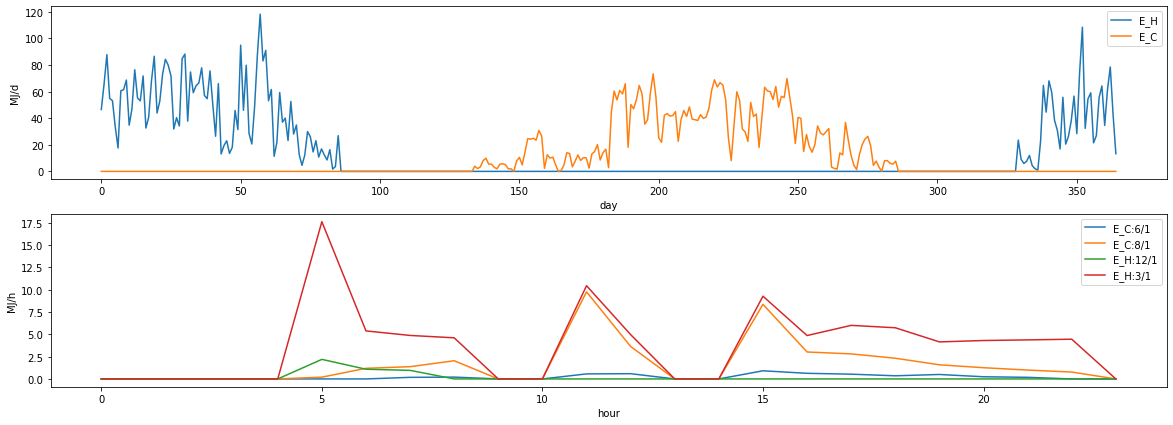

In [129]:
get_each_graph(E_H_d_t_2, E_C_d_t_2)

### 計算条件3

- 住戸、主居室、その他居室の床面積を90m2、25m2、40m2に変更
- 外皮面積の合計を250m2に変更

In [130]:
house_base, H_MR, H_OR, C_MR, C_OR, i = get_default_room_air_conditioner()
house_base['A_A'] = 90
house_base['A_MR'] = 25
house_base['A_OR'] = 40
house_base['A_env'] = 250

E_H_d_t_3, E_C_d_t_3 = calc_results(house_base, H_MR, H_OR, C_MR, C_OR, i)

E_H(i=1):10445.025743783193MJ/y
E_C(i=1):3218.995512434428MJ/y


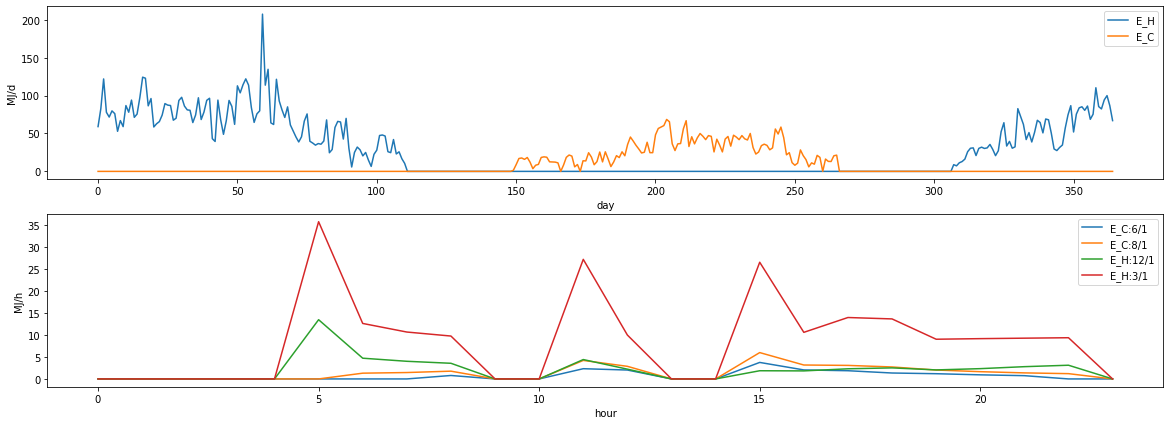

In [131]:
get_each_graph(E_H_d_t_3, E_C_d_t_3)

### 計算条件4

- 外皮平均熱貫流率を0.6に変更
- 暖房期平均日射熱取得率を3.0に変更
- 冷房期平均日射熱取得率を2.0に変更

In [132]:
house_base, H_MR, H_OR, C_MR, C_OR, i = get_default_room_air_conditioner()
house_base['U_A'] = 0.6
house_base['eta_A_H'] = 3.0
house_base['eta_A_C'] = 2.0

E_H_d_t_4, E_C_d_t_4 = calc_results(house_base, H_MR, H_OR, C_MR, C_OR, i)

E_H(i=1):8650.787048470258MJ/y
E_C(i=1):2766.2117613635437MJ/y


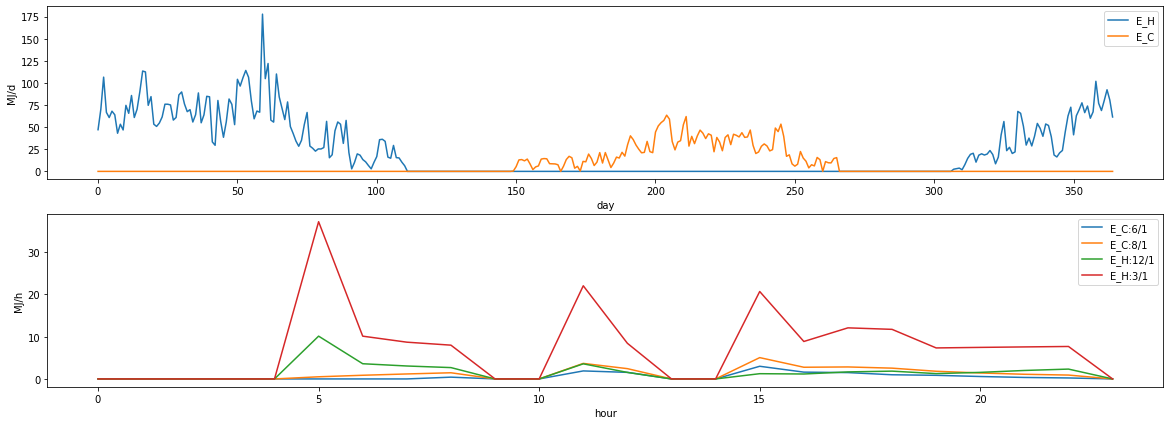

In [133]:
get_each_graph(E_H_d_t_4, E_C_d_t_4)

### 計算条件5

- 暖房：主居室のエネルギー消費効率の区分を「い」に変更
- 冷房：主居室のエネルギー消費効率の区分を「は」に変更

In [134]:
house_base, H_MR, H_OR, C_MR, C_OR, i = get_default_room_air_conditioner()
H_MR['e_class'] = 'い'
C_MR['e_class'] = 'は'

E_H_d_t_5, E_C_d_t_5 = calc_results(house_base, H_MR, H_OR, C_MR, C_OR, i)

E_H(i=1):10132.937050655002MJ/y
E_C(i=1):3525.9261521878484MJ/y


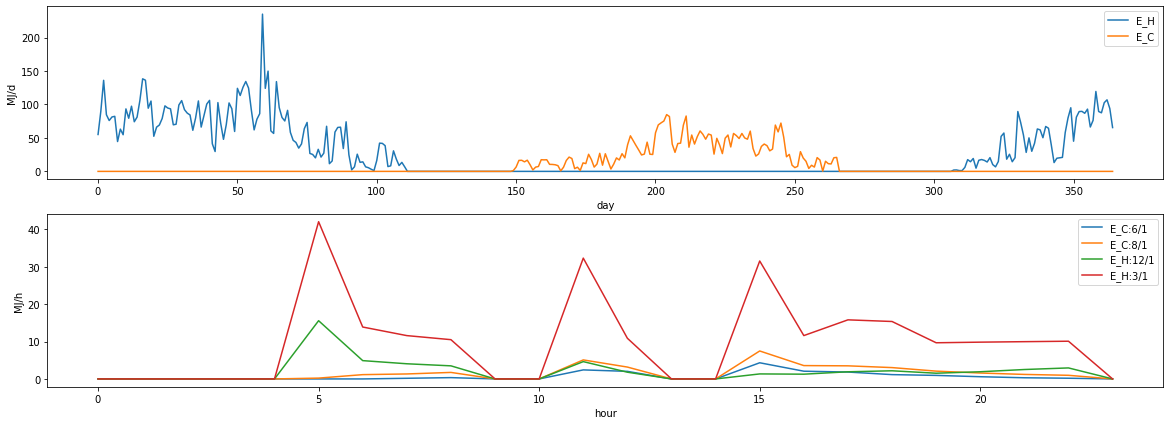

In [135]:
get_each_graph(E_H_d_t_5, E_C_d_t_5)

### 計算条件6

- 暖房：主居室のエネルギー消費効率の区分を「い」、小能力時高効率型コンプレッサーを搭載するに変更
- 冷房：主居室のエネルギー消費効率の区分を「は」、小能力時高効率型コンプレッサーを搭載するに変更

In [136]:
house_base, H_MR, H_OR, C_MR, C_OR, i = get_default_room_air_conditioner()
H_MR['e_class'] = 'い'
H_MR['dualcompressor'] = True
C_MR['e_class'] = 'は'
C_MR['dualcompressor'] = True

E_H_d_t_6, E_C_d_t_6 = calc_results(house_base, H_MR, H_OR, C_MR, C_OR, i)

E_H(i=1):9343.146066152913MJ/y
E_C(i=1):4333.085946079727MJ/y


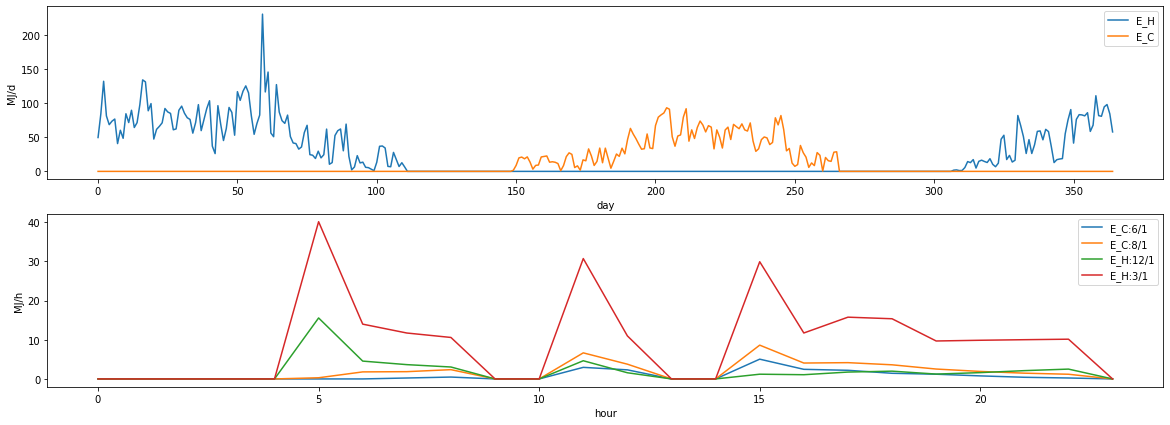

In [137]:
get_each_graph(E_H_d_t_6, E_C_d_t_6)

### 計算条件7

- 暖房：その他居室のエネルギー消費効率の区分を「ろ」に変更
- 冷房：その他居室のエネルギー消費効率の区分を「ろ」に変更
- 暖冷房区画を5に変更

In [138]:
house_base, H_MR, H_OR, C_MR, C_OR, i = get_default_room_air_conditioner()
H_OR = {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False}
C_OR = {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False}
i = 5

E_H_d_t_7, E_C_d_t_7 = calc_results(house_base, H_MR, H_OR, C_MR, C_OR, i)

E_H(i=5):1333.6552576682507MJ/y
E_C(i=5):906.343546096112MJ/y


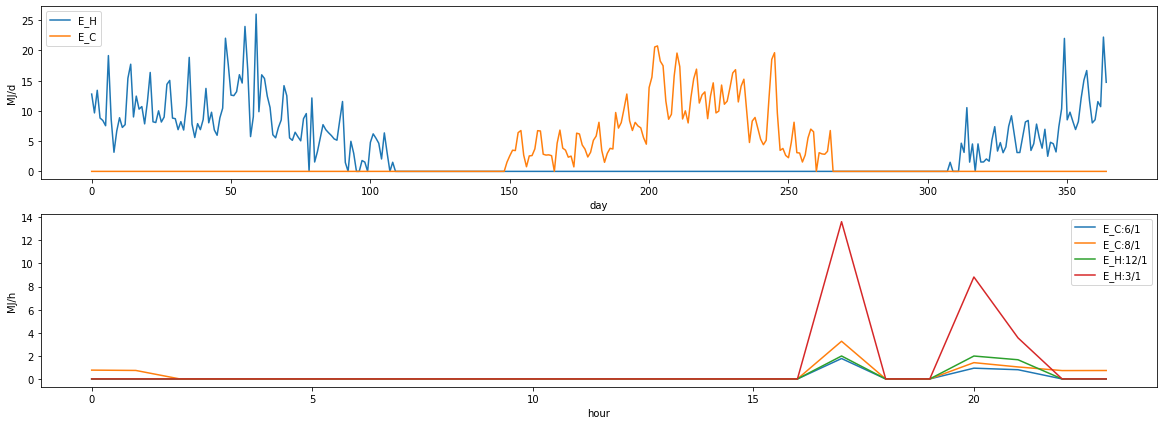

In [139]:
get_each_graph(E_H_d_t_7, E_C_d_t_7)

## 比較

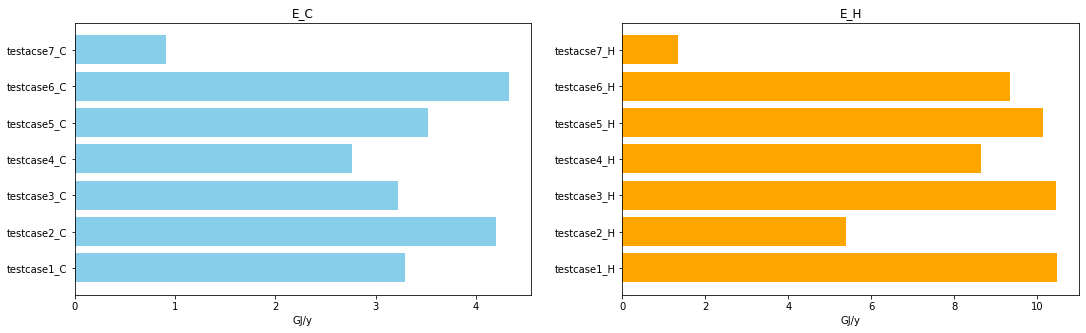

In [140]:
import matplotlib.pyplot as plt

dat_C = {"testcase1_C": np.sum(E_C_d_t_1)/1000, "testcase2_C": np.sum(E_C_d_t_2)/1000, "testcase3_C": np.sum(E_C_d_t_3)/1000, 
         "testcase4_C": np.sum(E_C_d_t_4)/1000, "testcase5_C": np.sum(E_C_d_t_5)/1000, "testcase6_C": np.sum(E_C_d_t_6)/1000,
         "testacse7_C": np.sum(E_C_d_t_7)/1000}
dat_H = {"testcase1_H": np.sum(E_H_d_t_1)/1000, "testcase2_H": np.sum(E_H_d_t_2)/1000, "testcase3_H": np.sum(E_H_d_t_3)/1000, 
         "testcase4_H": np.sum(E_H_d_t_4)/1000, "testcase5_H": np.sum(E_H_d_t_5)/1000, "testcase6_H": np.sum(E_H_d_t_6)/1000,
         "testacse7_H": np.sum(E_H_d_t_7)/1000}

x_C = list(dat_C.keys())
x_H = list(dat_H.keys())
y_C = list(dat_C.values())
y_H = list(dat_H.values())

fig = plt.figure(figsize=(18,5))
grh_C = fig.add_subplot(121)
grh_C.barh(x_C,y_C, color="skyblue")
grh_C.set_title("E_C")
grh_C.set_xlabel("GJ/y")

grh_H = fig.add_subplot(122)
grh_H.barh(x_H,y_H, color="orange")
grh_H.set_xlabel("GJ/y")
grh_H.set_title("E_H")

plt.show()